In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
# import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

# ### Functions used in this code
# import age_functions as afunc

## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [1]:
pwd

'/Users/joshpovick/Desktop/Research/SMC_Gradients'

In [3]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshpovick/Desktop/Research/SMC_Gradients/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

## Find Bloop
bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
bloop_cut = []
for i in range(len(smc)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

In [4]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('smc_apogee-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


In [10]:
# Distance Modulus 18.99 +/- .10 

# @ARTICLE{2000A&A...359..601C,
#        author = {{Cioni}, M. -R.~L. and {van der Marel}, R.~P. and {Loup}, C. and
#          {Habing}, H.~J.},
#         title = "{The tip of the red giant branch and distance of the Magellanic Clouds: results from the DENIS survey}",
#       journal = {\aap},
#      keywords = {METHODS: STATISTICAL, STARS: EVOLUTION, GALAXIES: MAGELLANIC CLOUDS, GALAXIES: DISTANCES AND REDSHIFTS, Astrophysics},
#          year = 2000,
#         month = jul,
#        volume = {359},
#         pages = {601-614},
# archivePrefix = {arXiv},
#        eprint = {astro-ph/0003223},
#  primaryClass = {astro-ph},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2000A&A...359..601C},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

In [157]:
#########################
### Import Isochrones ###
#########################

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/SMC_Gradients/parsec3_4.dat', \
                    format='basic', delimiter='\s')

parsec = parsecall[np.where(parsecall['label']==3)]

parsec9351010 = ascii.read('/Users/joshpovick/Desktop/Research/SMC_Gradients/parsec3_49351010.dat', \
                    format='basic', delimiter='\s')

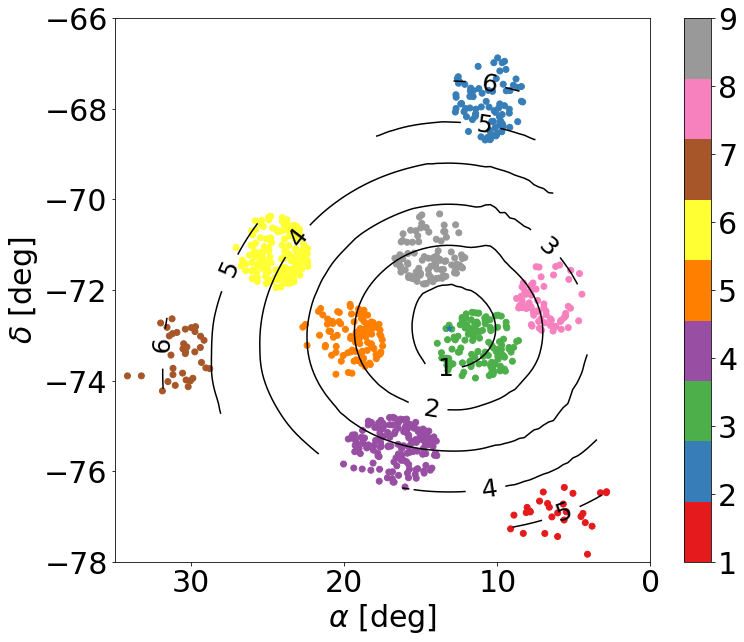

In [40]:
################
### smc_nobloop Map ###
###############

### Map

from scipy.interpolate import griddata

radius = smc_nobloop['SMCRAD']*1.05

xx,yy = np.meshgrid(np.linspace(np.min(smc_nobloop['RA']),np.max(smc_nobloop['RA']),100),
                    np.linspace(np.min(smc_nobloop['DEC']),np.max(smc_nobloop['DEC']),100))

points = np.array([smc_nobloop['RA'],smc_nobloop['DEC']]).T

grid_z0 = griddata(points, radius, (xx, yy), method='cubic')

field_color = []
for i in range(len(smc_nobloop)):
    if smc_nobloop['FIELD'][i] == '47TUC':
        field_color.append(8.0)
    if smc_nobloop['FIELD'][i] == 'N362':
        field_color.append(9.0)
    if smc_nobloop['FIELD'][i] == 'SMC1':
        field_color.append(1.0)
    if smc_nobloop['FIELD'][i] == 'SMC2':
        field_color.append(2.0)
    if smc_nobloop['FIELD'][i] == 'SMC3':
        field_color.append(3.0)
    if smc_nobloop['FIELD'][i] == 'SMC4':
        field_color.append(4.0)
    if smc_nobloop['FIELD'][i] == 'SMC5':
        field_color.append(5.0)
    if smc_nobloop['FIELD'][i] == 'SMC6':
        field_color.append(6.0)
    if smc_nobloop['FIELD'][i] == 'SMC7':
        field_color.append(7.0)

matplotlib.rcParams.update({'font.size': 30})
# plt.figure(figsize=[12,12])

fig, ax = plt.subplots(figsize=[12,10])

plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],c=field_color,cmap='Set1')
plt.colorbar()

plt.scatter(13.18333333,-72.82833333,marker='*')

plt.xlim(0,35)
plt.ylim(-78,-66)

plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

CS = plt.contour(xx,yy,grid_z0*1.05,levels=[1,2,3,4,5,6],colors='k')
plt.clabel(CS,fmt='%2.1d',colors='k',fontsize=25)#,manual=locations)

# plt.xticks([-8,-4.0,0,4.0,8])
# plt.yticks([-8,-4.0,0,4.0,8])

plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

# plt.savefig('smc_nobloopGeometry.pdf',bbox_inches='tight')
plt.show()

In [41]:
################################
### Individual APOGEE Fields ###
################################

tuc47 = np.where(smc_nobloop['FIELD']=='47TUC')
tuc47 = smc_nobloop[tuc47]

n362 = np.where(smc_nobloop['FIELD']=='N362')
n362 = smc_nobloop[n362]

smc1 = np.where(smc_nobloop['FIELD']=='SMC1')
smc1 = smc_nobloop[smc1]

smc2 = np.where(smc_nobloop['FIELD']=='SMC2')
smc2 = smc_nobloop[smc2]

smc3 = np.where(smc_nobloop['FIELD']=='SMC3')
smc3 = smc[smc3]

smc4 = np.where(smc_nobloop['FIELD']=='SMC4')
smc4 = smc_nobloop[smc4]

smc5 = np.where(smc_nobloop['FIELD']=='SMC5')
smc5 = smc_nobloop[smc5]

smc6 = np.where(smc_nobloop['FIELD']=='SMC6')
smc6 = smc_nobloop[smc6]

smc7 = np.where(smc_nobloop['FIELD']=='SMC7')
smc7 = smc_nobloop[smc7]

In [42]:
##############################
### Individual Gaia Fields ###
##############################

def euclid(x,y,h,k):
    '''
    Calculate the distance from some point (h,k)
    
    Inputs:
    ------
        x: x coordinate(s) of point(s)
        y: y coordinate(s) of point(s)
        h: x coordinate of reference point
        k: y coordinate of reference point
    
    Output:
    ------
        r: distance between (x,y) and (h,k)
    '''
    
    r = np.sqrt(np.subtract(x,h)**2+np.subtract(y,k)**2)
    
    return r

gaia47 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(tuc47['RA']),np.median(tuc47['DEC']))<=1.)]
gaia362 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(n362['RA']),np.median(n362['DEC']))<=1.)]
gaia1 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc1['RA']),np.median(smc1['DEC']))<=1.)]
gaia2 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc2['RA']),np.median(smc2['DEC']))<=1.)]
gaia3 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc3['RA']),np.median(smc3['DEC']))<=1.)]
gaia4 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc4['RA']),np.median(smc4['DEC']))<=1.)]
gaia5 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc5['RA']),np.median(smc5['DEC']))<=1.)]
gaia6 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc6['RA']),np.median(smc6['DEC']))<=1.)]
gaia7 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc7['RA']),np.median(smc7['DEC']))<=1.)]

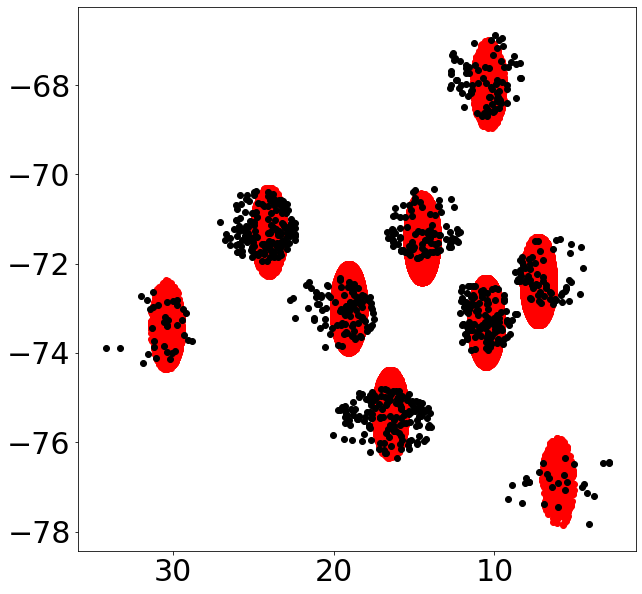

In [44]:
gaia_ras = [gaia47['ra'],gaia362['ra'],gaia1['ra'],gaia2['ra'],gaia3['ra'],gaia4['ra'],gaia5['ra'],gaia6['ra'],
            gaia7['ra']]
gaia_decs = [gaia47['dec'],gaia362['dec'],gaia1['dec'],gaia2['dec'],gaia3['dec'],gaia4['dec'],gaia5['dec'],
             gaia6['dec'],gaia7['dec']]
smc_ras = [tuc47['ra'],n362['ra'],smc1['ra'],smc2['ra'],smc3['ra'],smc4['ra'],smc5['ra'],smc6['ra'],
            smc7['ra']]
smc_decs = [tuc47['dec'],n362['dec'],smc1['dec'],smc2['dec'],smc3['dec'],smc4['dec'],smc5['dec'],
             smc6['dec'],smc7['dec']]
smc_col = [8.*np.ones(len(smc_ras[0])),9.*np.ones(len(smc_ras[1])),1.*np.ones(len(smc_ras[2])),
           2.*np.ones(len(smc_ras[3])),3.*np.ones(len(smc_ras[4])),4.*np.ones(len(smc_ras[5])),
           5.*np.ones(len(smc_ras[6])),6.*np.ones(len(smc_ras[7])),7.*np.ones(len(smc_ras[8]))]

plt.figure(figsize=[10,10])
for i in range(len(gaia_ras)):
    plt.scatter(gaia_ras[i],gaia_decs[i],c='r',zorder=1)
    plt.scatter(smc_ras[i],smc_decs[i],c='k',zorder=2)

plt.gca().invert_xaxis()
plt.show()

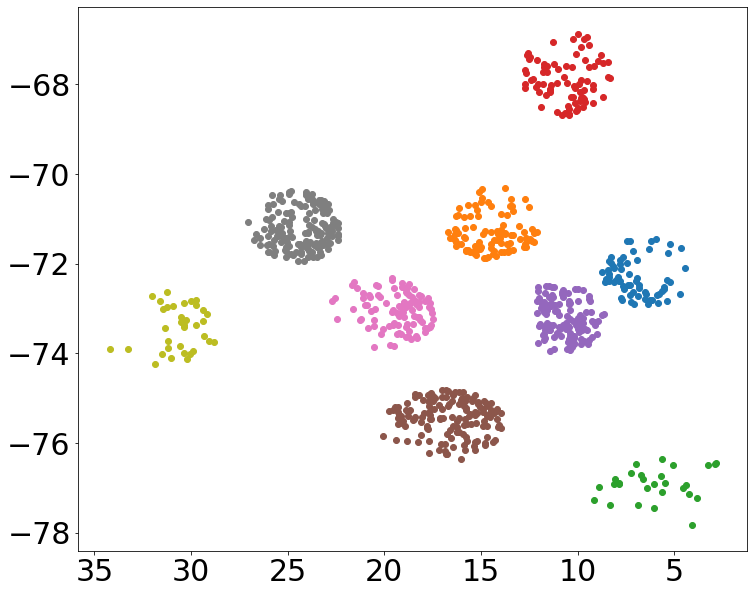

In [28]:
smc_col[1]

array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.])

<font size='15'>
    <b>
        CMD
    </b>
<font>

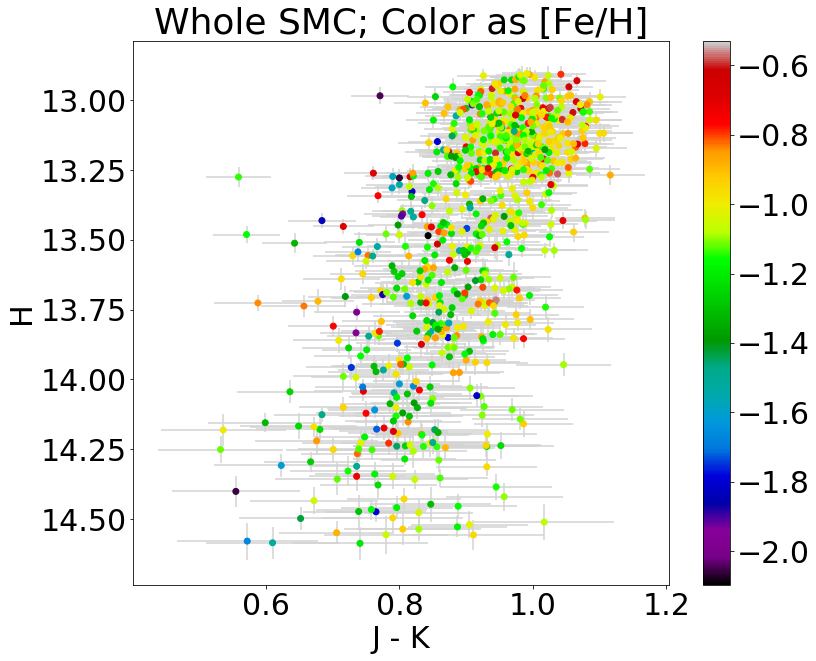

In [270]:
col_err = np.sqrt(smc_nobloop['J_ERR']**2+smc_nobloop['K_ERR']**2)

plt.figure(figsize=[12,10])
plt.errorbar(smc_nobloop['J']-smc_nobloop['K'],smc_nobloop['H'],yerr=smc_nobloop['H_ERR'],xerr=col_err,
             c='lightgray',zorder=1,ls='none')
plt.scatter(smc_nobloop['J']-smc_nobloop['K'],smc_nobloop['H'],c=smc_nobloop['FE_H'],
            cmap='nipy_spectral',zorder=2)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Whole SMC; Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'H')

plt.show()

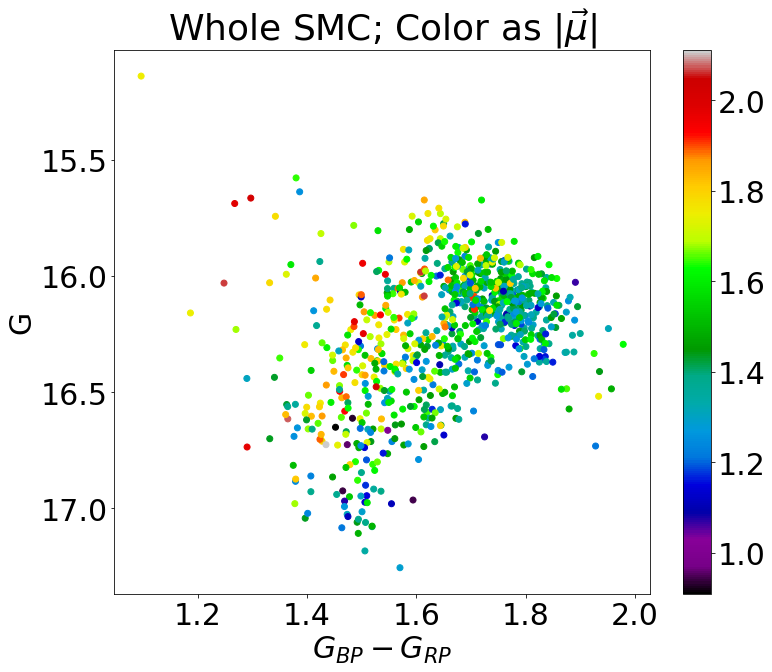

In [271]:
col_err = np.sqrt(smc_nobloop['J_ERR']**2+smc_nobloop['K_ERR']**2)

plt.figure(figsize=[12,10])
# plt.errorbar(smc_nobloop['GAIA_GMAG']-smc_nobloop['GAIA_BPMAG'],smc_nobloop['GAIA_GMAG'],
#              xerr=smc_nobloop['K_ERR'],yerr=col_err,
#              c='lightgray',zorder=1,ls='none')
plt.scatter(smc_nobloop['GAIA_BPMAG']-smc_nobloop['GAIA_RPMAG'],smc_nobloop['GAIA_GMAG'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2),cmap='nipy_spectral',zorder=2)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Whole SMC; Color as $|\vec{\mu}|$')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'G')

plt.show()

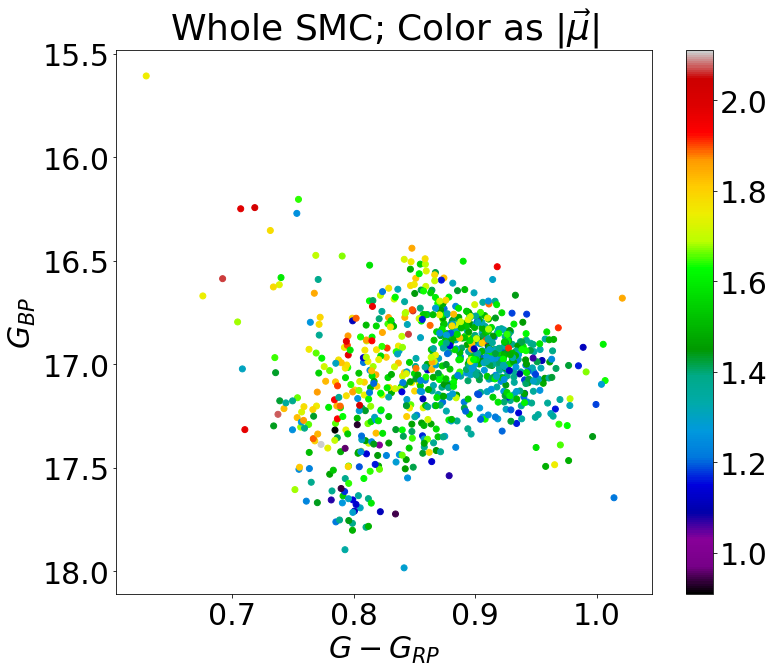

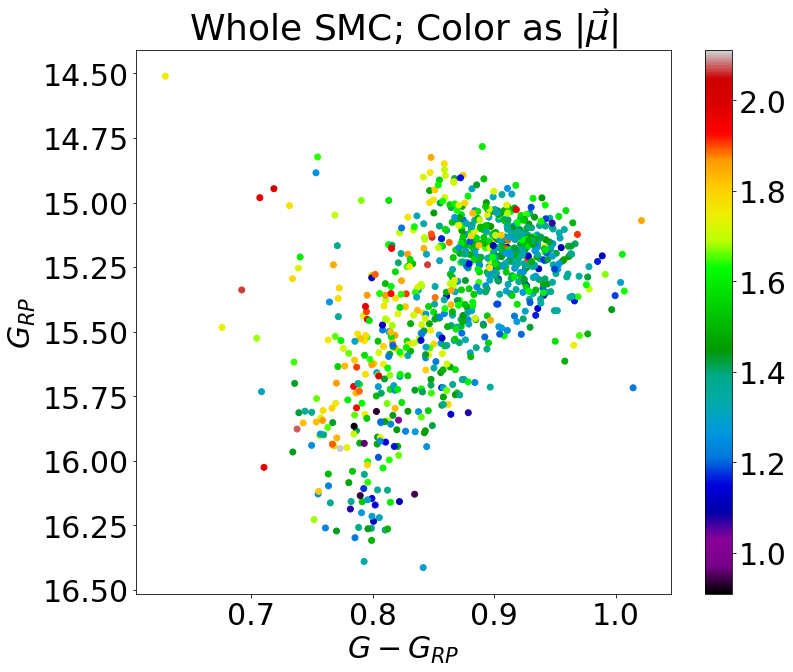

In [268]:
plt.figure(figsize=[12,10])
# plt.errorbar(smc_nobloop['GAIA_GMAG']-smc_nobloop['GAIA_BPMAG'],smc_nobloop['GAIA_GMAG'],
#              xerr=smc_nobloop['K_ERR'],yerr=col_err,
#              c='lightgray',zorder=1,ls='none')
plt.scatter(smc_nobloop['GAIA_GMAG']-smc_nobloop['GAIA_RPMAG'],smc_nobloop['GAIA_BPMAG'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2),cmap='nipy_spectral',zorder=2)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Whole SMC; Color as $|\vec{\mu}|$')
plt.xlabel(r'$G - G_{RP}$')
plt.ylabel(r'$G_{BP}$')

plt.show()

plt.figure(figsize=[12,10])
# plt.errorbar(smc_nobloop['GAIA_GMAG']-smc_nobloop['GAIA_BPMAG'],smc_nobloop['GAIA_GMAG'],
#              xerr=smc_nobloop['K_ERR'],yerr=col_err,
#              c='lightgray',zorder=1,ls='none')
plt.scatter(smc_nobloop['GAIA_GMAG']-smc_nobloop['GAIA_RPMAG'],smc_nobloop['GAIA_RPMAG'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2),cmap='nipy_spectral',zorder=2)
plt.colorbar()
plt.gca().invert_yaxis()

plt.title(r'Whole SMC; Color as $|\vec{\mu}|$')
plt.xlabel(r'$G - G_{RP}$')
plt.ylabel(r'$G_{RP}$')

plt.show()

In [49]:
### List of Fields

fields = ['47 TUC', 'NGC 362', 'SMC1', 'SMC2', 'SMC3', 'SMC4', 'SMC5', 'SMC6', 'SMC7']

### List of J-K color for each field
fieldcols = [tuc47['J']-tuc47['K'],n362['J']-n362['K'],smc1['J']-smc1['K'],smc2['J']-smc2['K'],
             smc3['J']-smc3['K'],smc4['J']-smc4['K'],smc5['J']-smc5['K'],smc6['J']-smc6['K'],smc7['J']-smc7['K']]
fieldcols_err = [np.sqrt(tuc47['J_ERR']**2+tuc47['K_ERR']**2),np.sqrt(n362['J_ERR']**2+n362['K_ERR']**2),
                 np.sqrt(smc1['J_ERR']**2+smc1['K_ERR']**2),np.sqrt(smc2['J_ERR']**2+smc2['K_ERR']**2),
                 np.sqrt(smc3['J_ERR']**2+smc3['K_ERR']**2),np.sqrt(smc4['J_ERR']**2+smc4['K_ERR']**2),
                 np.sqrt(smc5['J_ERR']**2+smc5['K_ERR']**2),np.sqrt(smc6['J_ERR']**2+smc6['K_ERR']**2),
                 np.sqrt(smc7['J_ERR']**2+smc7['K_ERR']**2)]

### List of H for each field
fieldh = [tuc47['H'],n362['H'],smc1['H'],smc2['H'],smc3['H'],smc4['H'],smc5['H'],smc6['H'],smc7['H']]
fieldh_err = [tuc47['H_ERR'],n362['H_ERR'],smc1['H_ERR'],smc2['H_ERR'],smc3['H_ERR'],smc4['H_ERR'],smc5['H_ERR'],
              smc6['H_ERR'],smc7['H_ERR']]

### List of Metallicities
fieldfeh = [tuc47['FE_H'],n362['FE_H'],smc1['FE_H'],smc2['FE_H'],smc3['FE_H'],smc4['FE_H'],smc5['FE_H'],
            smc6['FE_H'],smc7['FE_H']]
fieldfeh_err = [tuc47['FE_H_ERR'],n362['FE_H_ERR'],smc1['FE_H_ERR'],smc2['FE_H_ERR'],smc3['FE_H_ERR'],
                smc4['FE_H_ERR'],smc5['FE_H_ERR'],smc6['FE_H_ERR'],smc7['FE_H_ERR']]

### List of Gaia G mag for each field
fieldg = [tuc47['GAIA_GMAG'],n362['GAIA_GMAG'],smc1['GAIA_GMAG'],smc2['GAIA_GMAG'],smc3['GAIA_GMAG'],
          smc4['GAIA_GMAG'],smc5['GAIA_GMAG'],smc6['GAIA_GMAG'],smc7['GAIA_GMAG']]
# fieldg_err = [tuc47['GAIA_GMAG_ERR'],n362['GAIA_GMAG_ERR'],smc1['GAIA_GMAG_ERR'],smc2['GAIA_GMAG_ERR'],
#               smc3['GAIA_GMAG_ERR'],smc4['GAIA_GMAG_ERR'],smc5['GAIA_GMAG_ERR'],smc6['GAIA_GMAG_ERR'],
#               smc7['GAIA_GMAG_ERR']]

### List of Gaia BP - RP Color
fieldgcols = [tuc47['GAIA_BPMAG']-tuc47['GAIA_RPMAG'],n362['GAIA_BPMAG']-n362['GAIA_RPMAG'],
             smc1['GAIA_BPMAG']-smc1['GAIA_RPMAG'],smc2['GAIA_BPMAG']-smc2['GAIA_RPMAG'],
             smc3['GAIA_BPMAG']-smc3['GAIA_RPMAG'],smc4['GAIA_BPMAG']-smc4['GAIA_RPMAG'],
             smc5['GAIA_BPMAG']-smc5['GAIA_RPMAG'],smc6['GAIA_BPMAG']-smc6['GAIA_RPMAG'],
             smc7['GAIA_BPMAG']-smc7['GAIA_RPMAG']]

# fieldcols_err = [np.sqrt(tuc47['GAIA_BPMAG_ERR']**2+tuc47['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(n362['GAIA_BPMAG_ERR']**2+n362['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc1['GAIA_BPMAG_ERR']**2+smc1['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc2['GAIA_BPMAG_ERR']**2+smc2['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc3['GAIA_BPMAG_ERR']**2+smc3['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc4['GAIA_BPMAG_ERR']**2+smc4['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc5['GAIA_BPMAG_ERR']**2+smc5['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc6['GAIA_BPMAG_ERR']**2+smc6['GAIA_RPMAG_ERR']**2),
#                  np.sqrt(smc7['GAIA_BPMAG_ERR']**2+smc7['GAIA_RPMAG_ERR']**2)]

### List of Proper Motions
fieldpms = [np.sqrt(tuc47['GAIA_PMRA']**2+tuc47['GAIA_PMDEC']**2),
            np.sqrt(n362['GAIA_PMRA']**2+n362['GAIA_PMDEC']**2),
            np.sqrt(smc1['GAIA_PMRA']**2+smc1['GAIA_PMDEC']**2),
            np.sqrt(smc2['GAIA_PMRA']**2+smc2['GAIA_PMDEC']**2),
            np.sqrt(smc3['GAIA_PMRA']**2+smc3['GAIA_PMDEC']**2),
            np.sqrt(smc4['GAIA_PMRA']**2+smc4['GAIA_PMDEC']**2),
            np.sqrt(smc5['GAIA_PMRA']**2+smc5['GAIA_PMDEC']**2),
            np.sqrt(smc6['GAIA_PMRA']**2+smc6['GAIA_PMDEC']**2),
            np.sqrt(smc7['GAIA_PMRA']**2-smc7['GAIA_PMDEC']**2)]
# fieldpms_err = 

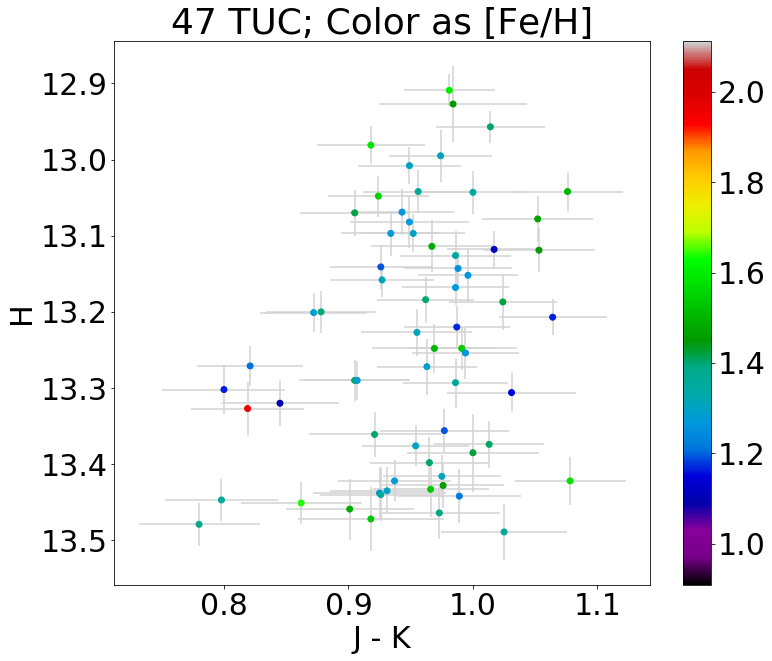

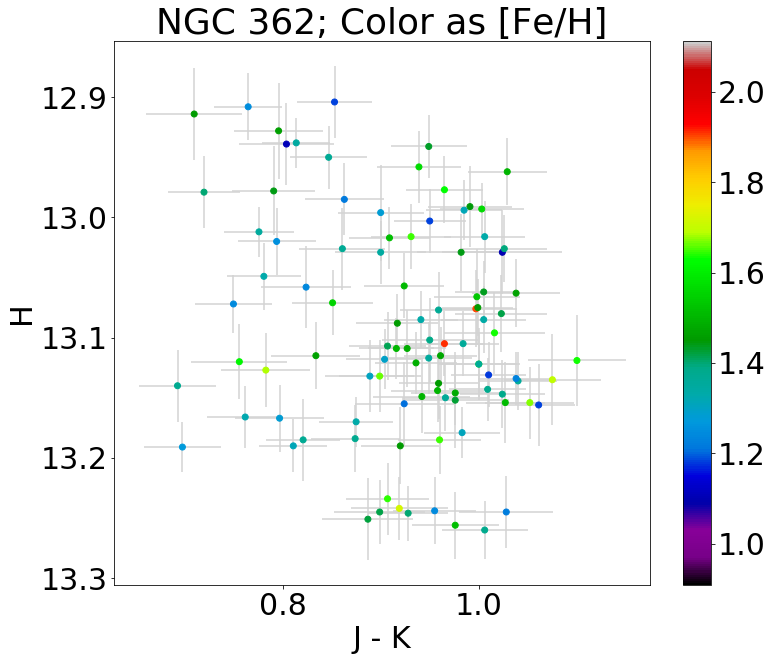

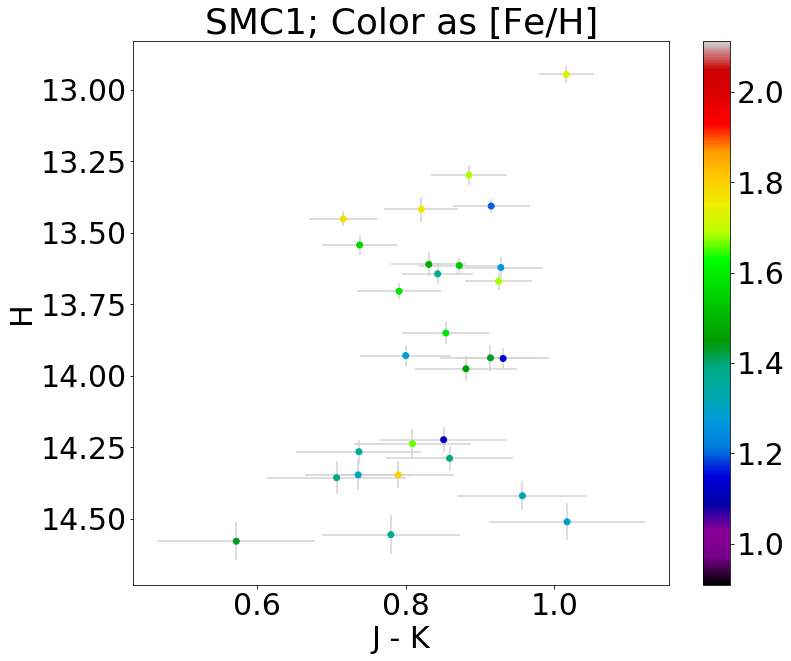

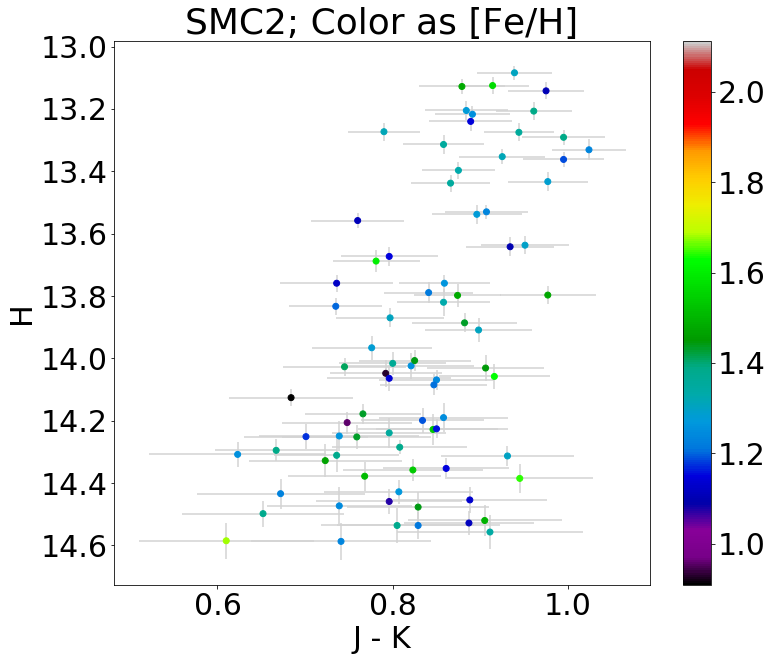

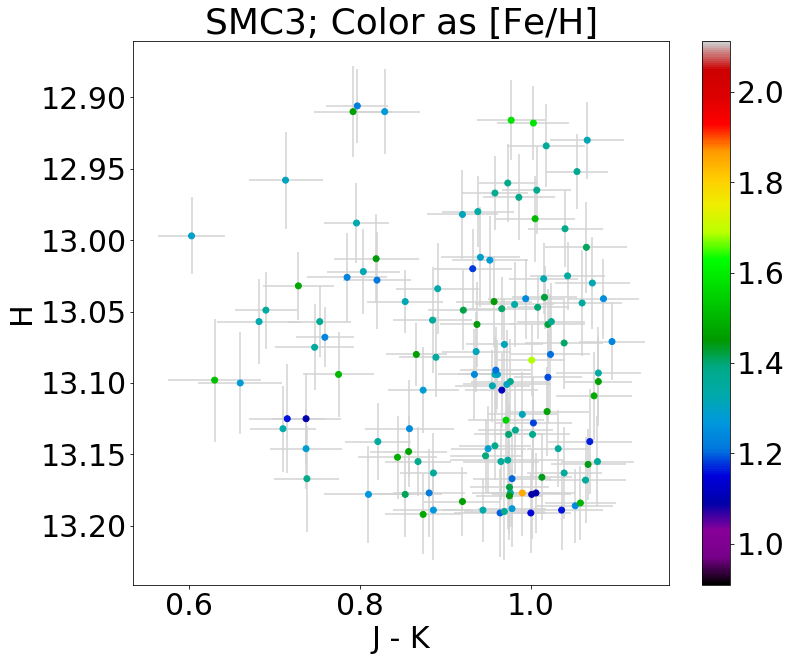

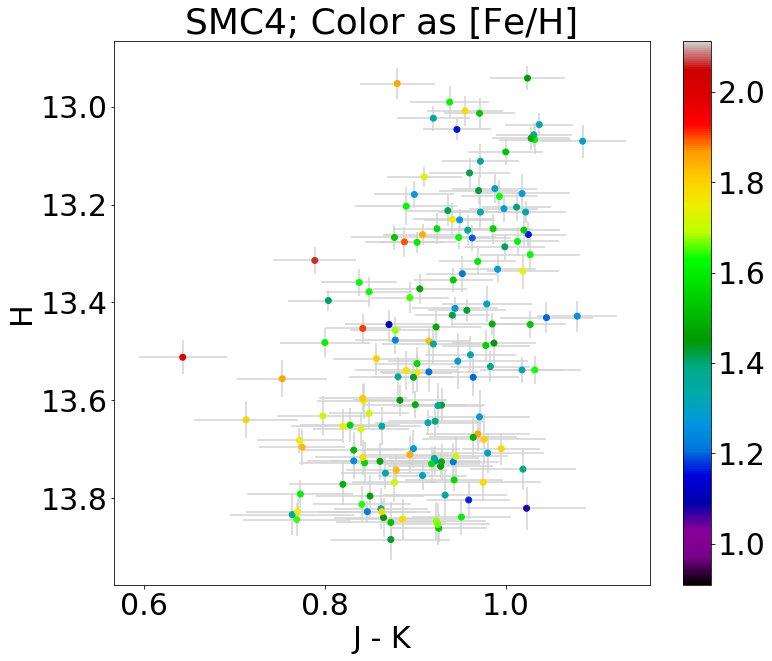

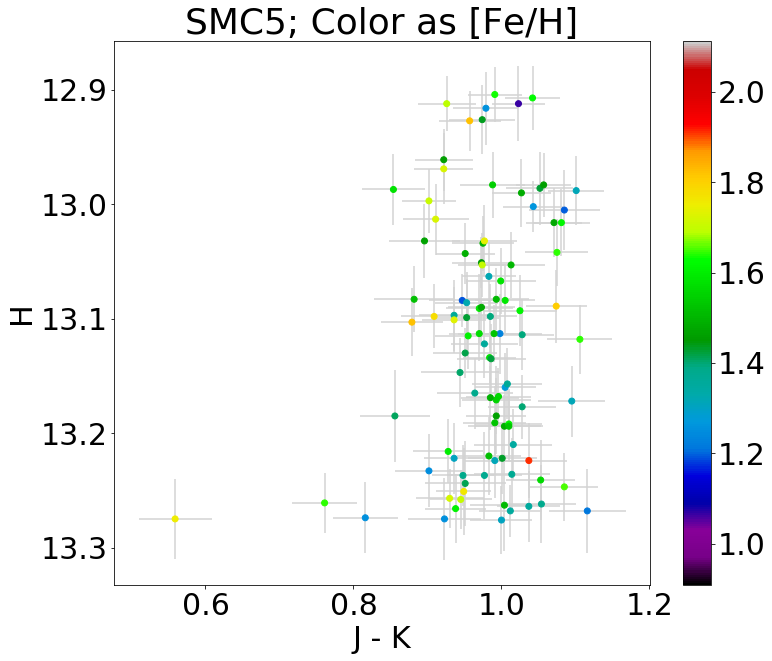

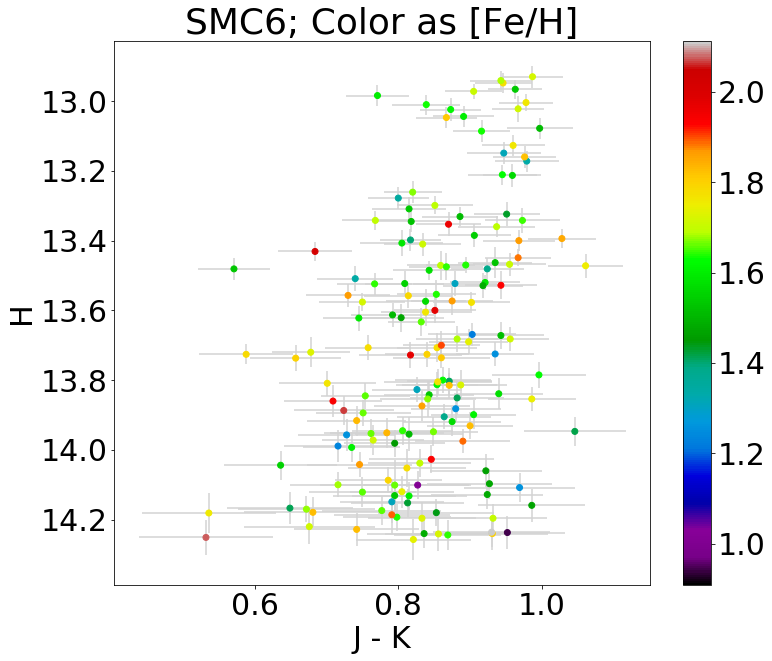

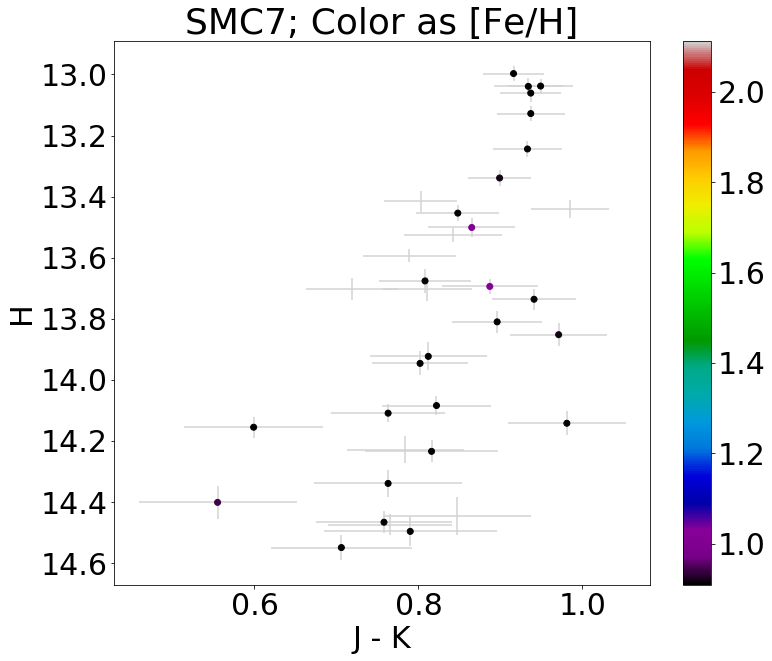

In [56]:
###############################
### Plot Field by Field CMD ###
###############################

for i in range(len(fieldcols)):
    plt.figure(figsize=[12,10])
    plt.errorbar(fieldcols[i],fieldh[i],xerr=fieldcols_err[i],yerr=fieldh_err[i],
                 c='lightgray',zorder=1,ls='none')
    plt.scatter(fieldcols[i],fieldh[i],c=fieldpms[i],cmap='nipy_spectral',
                zorder=2,vmax=max(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)),
                vmin=min(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)))
    plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}; Color as Proper Motion'.format(fields[i]))
    plt.xlabel(r'J - K')
    plt.ylabel(r'H')

    plt.show()
    
    

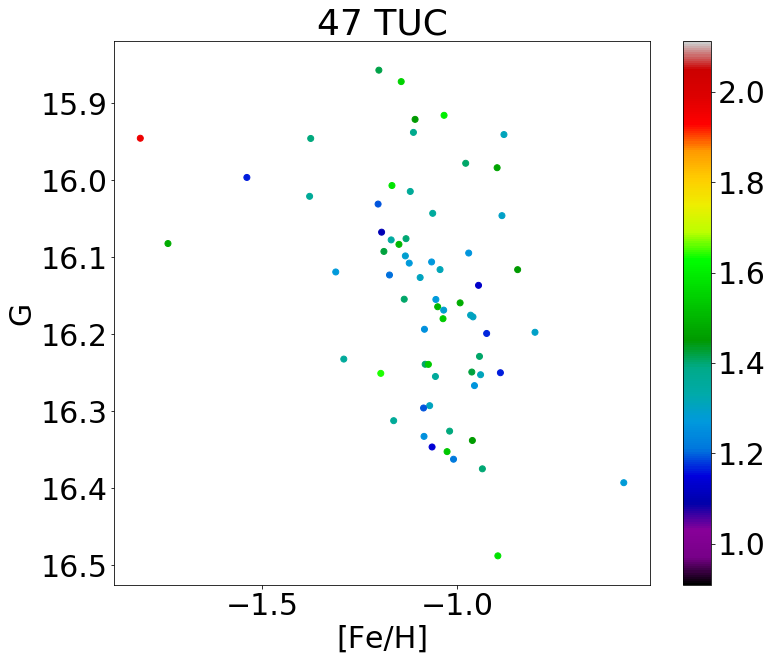

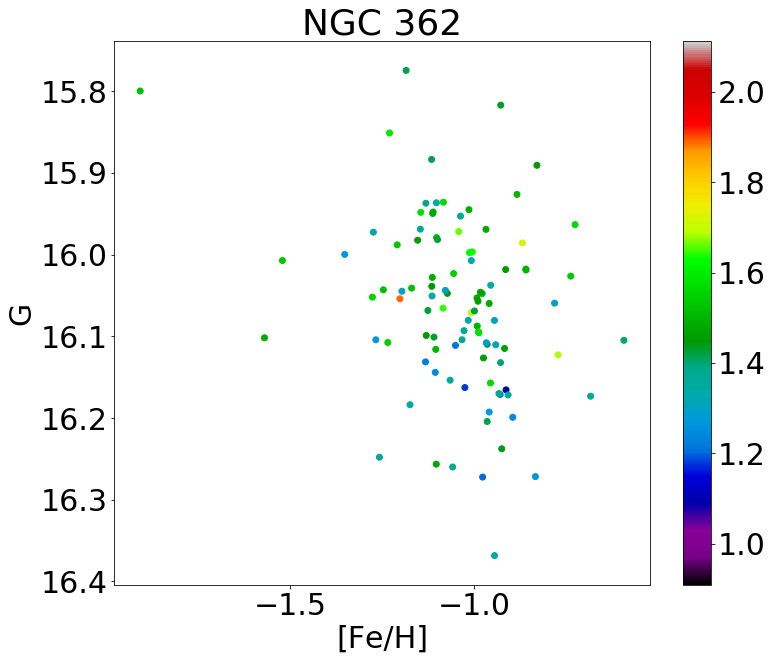

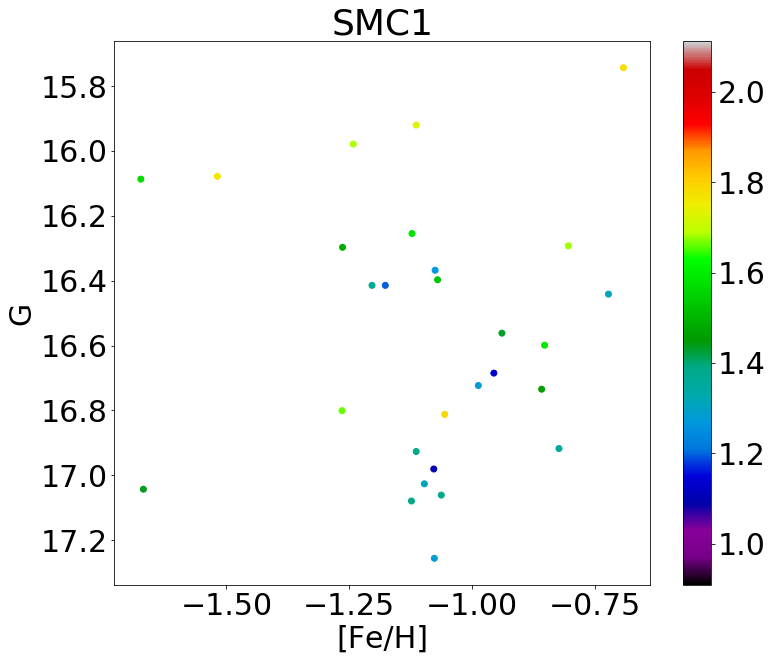

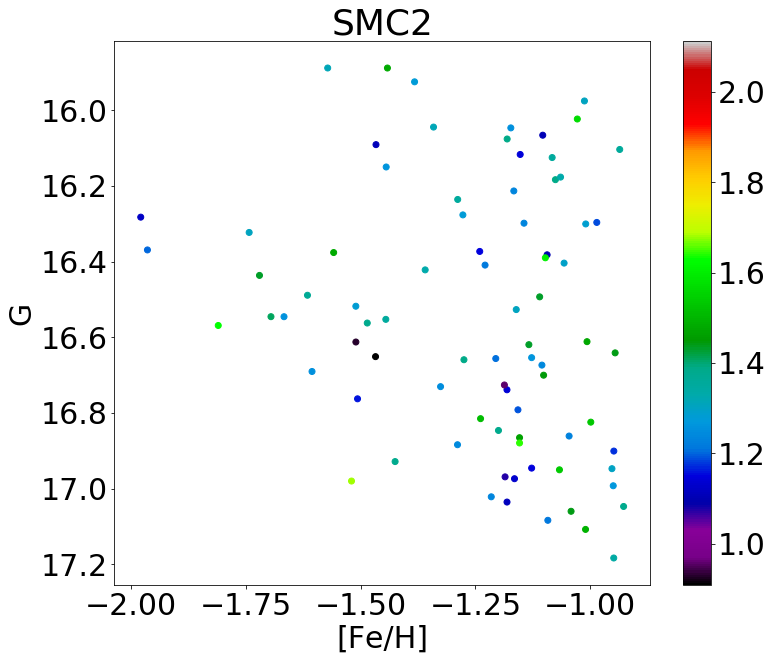

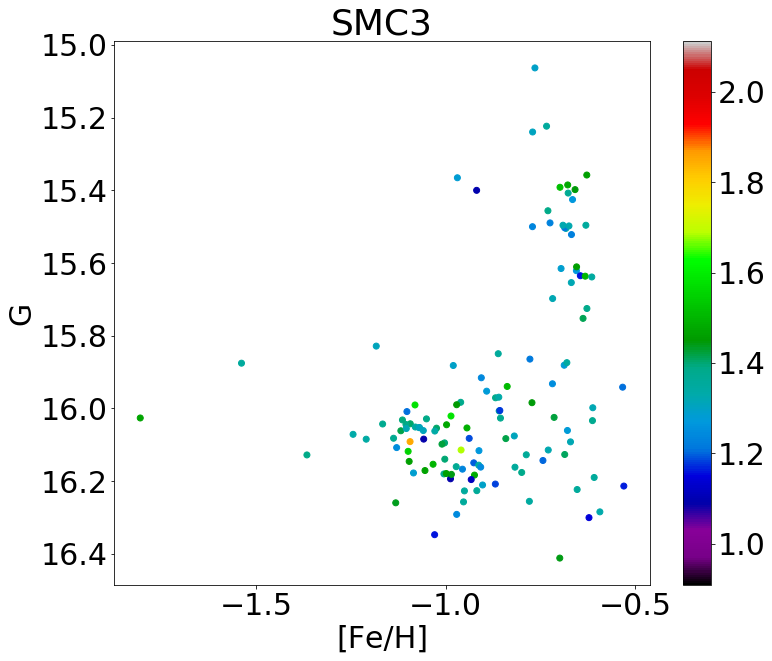

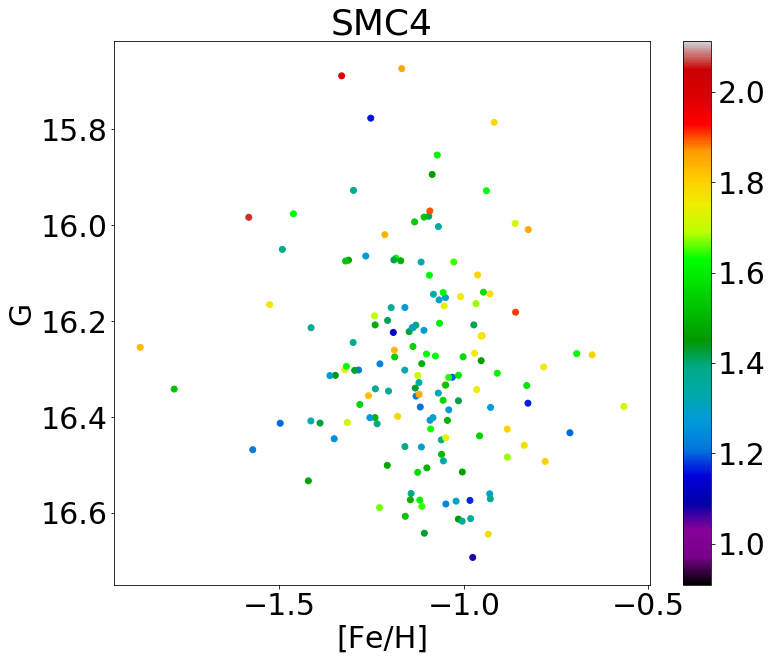

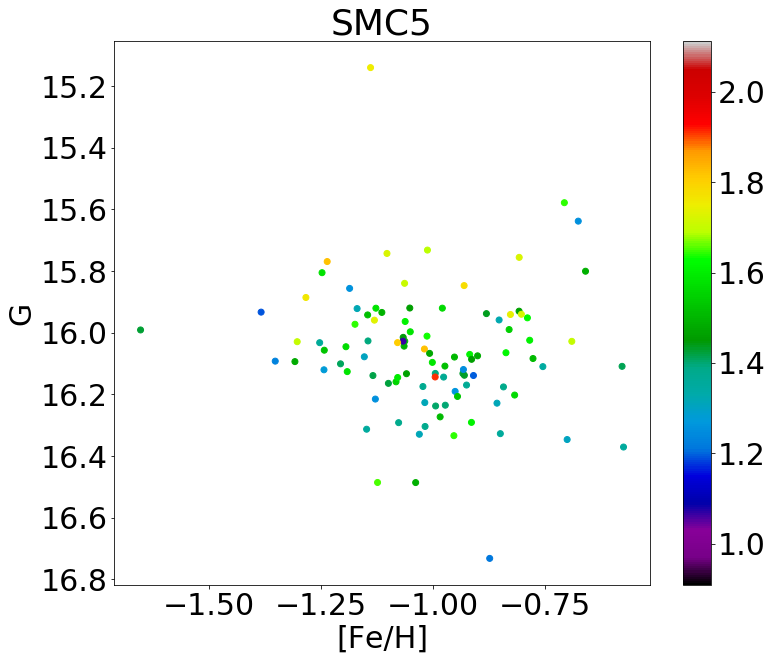

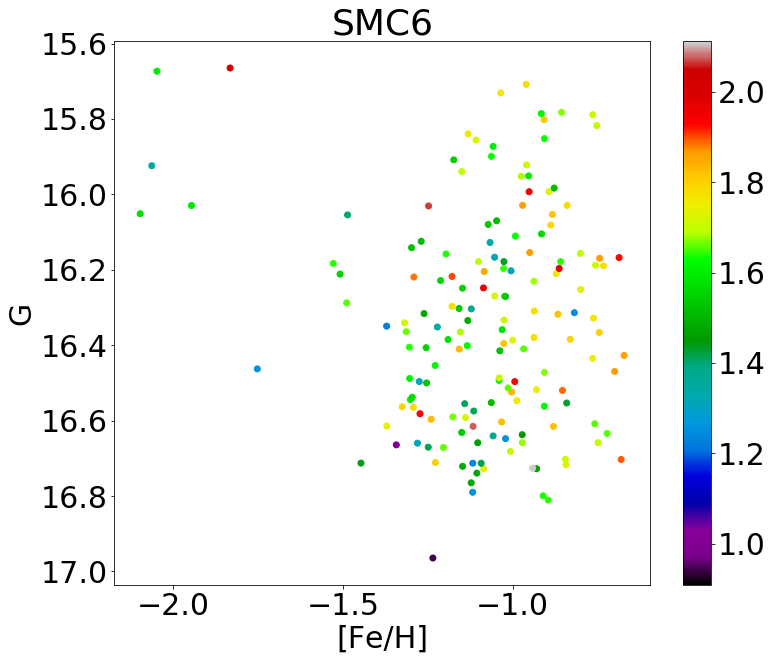

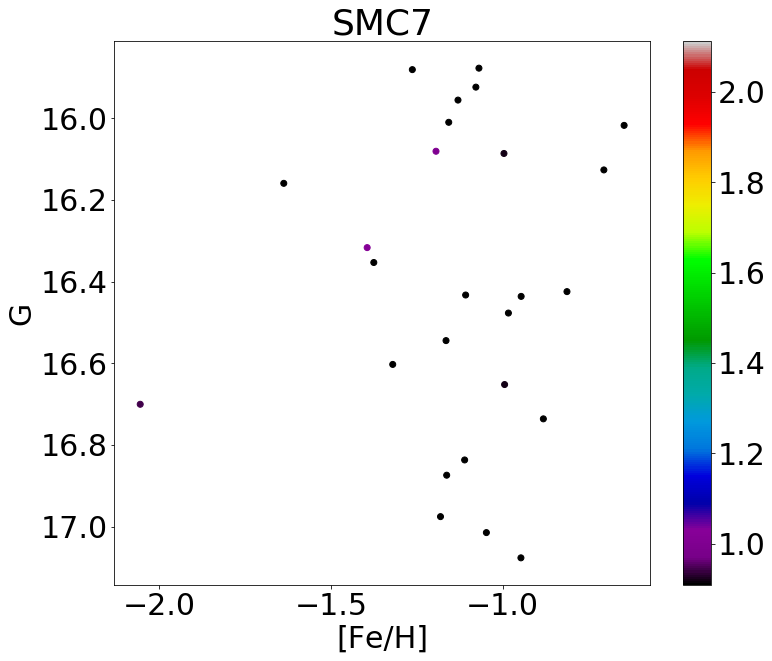

In [167]:
for i in range(len(fieldcols)):
    plt.figure(figsize=[12,10])
#     plt.errorbar(fieldcols[i],fieldh[i],xerr=fieldcols_err[i],yerr=fieldh_err[i],
#                  c='lightgray',zorder=1,ls='none')
    plt.scatter(fieldfeh[i],fieldg[i],c=fieldpms[i],cmap='nipy_spectral',
                zorder=2,vmax=max(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)),
                vmin=min(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)))
    
    plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}'.format(fields[i]))
    plt.xlabel(r'[Fe/H]')
    plt.ylabel(r'G')

    plt.show()

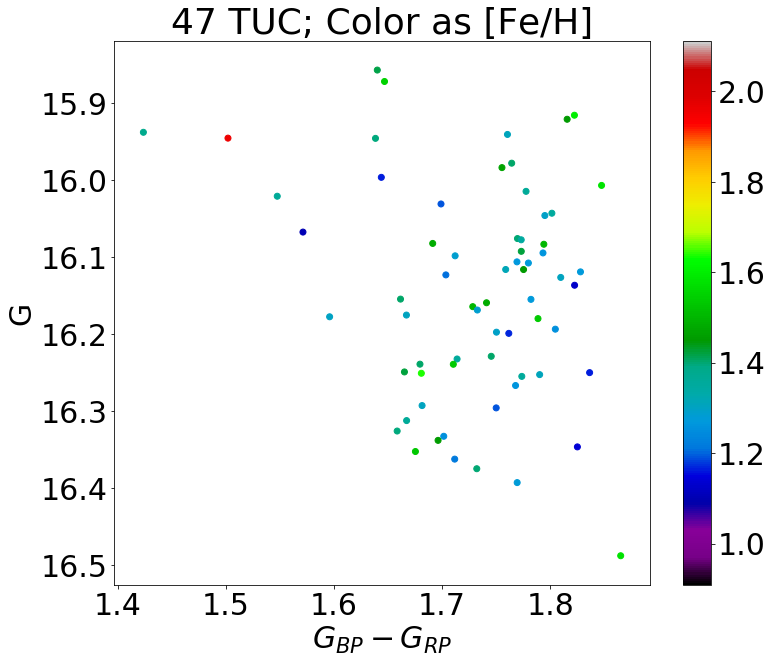

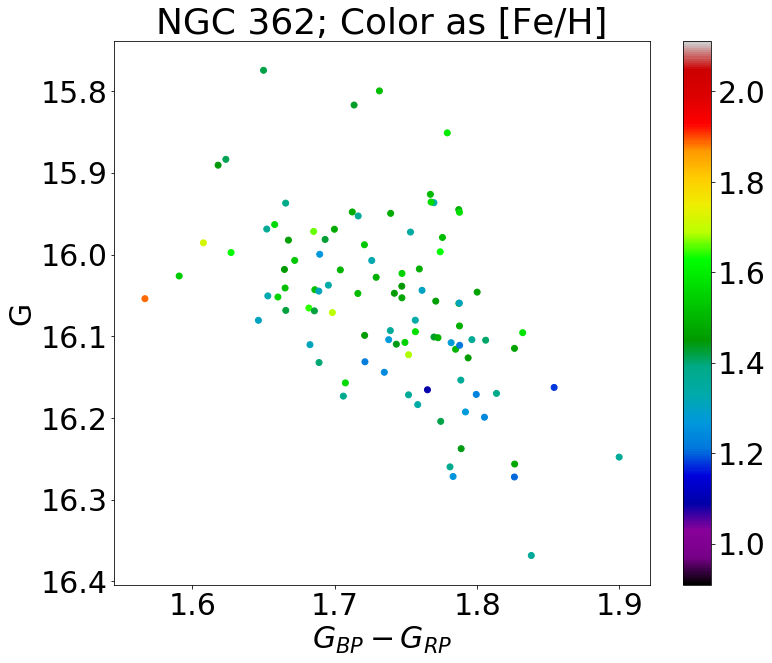

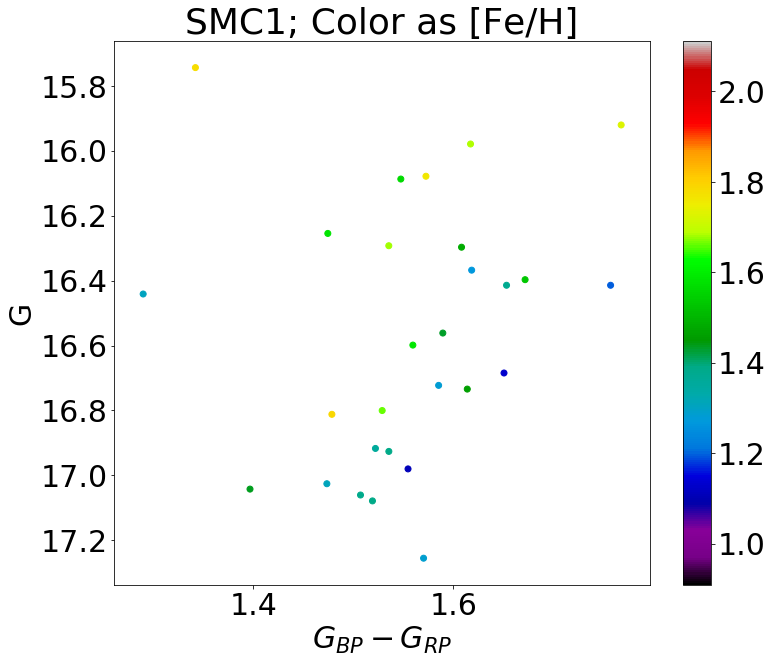

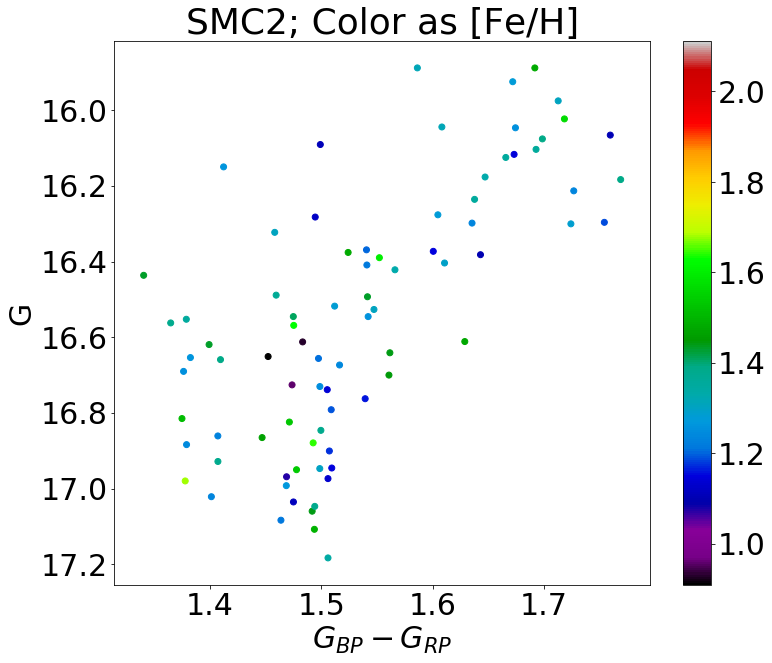

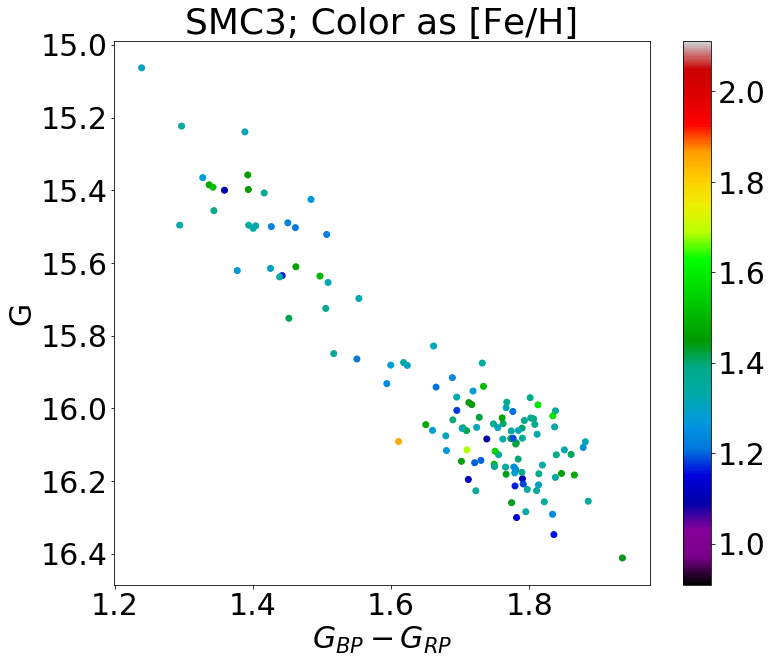

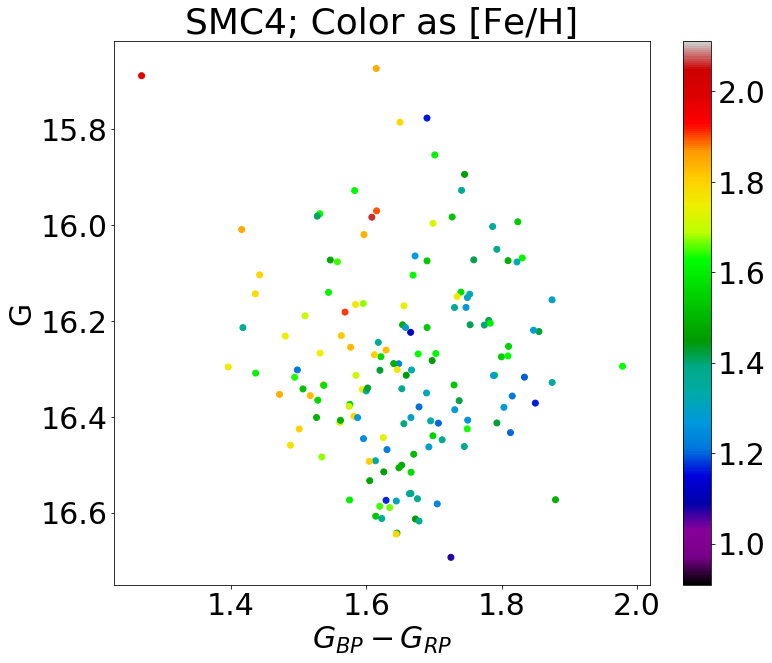

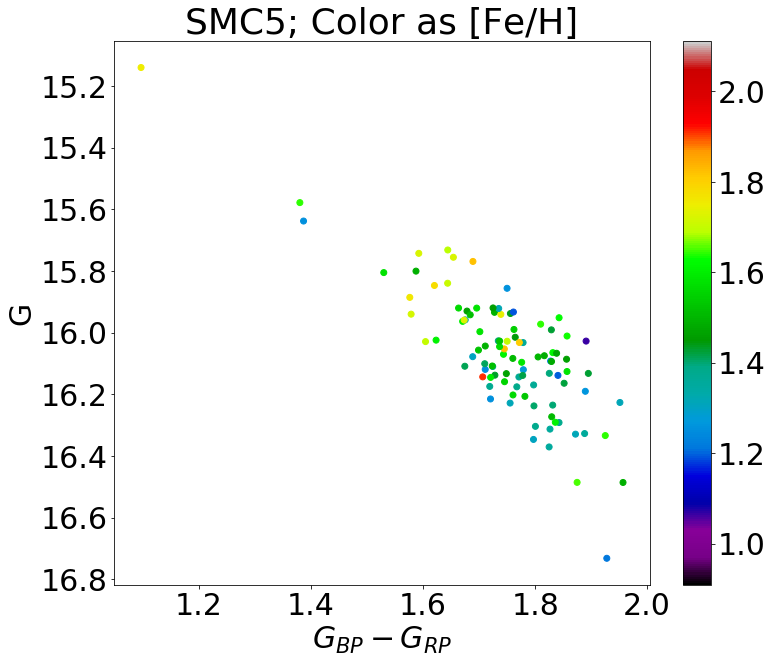

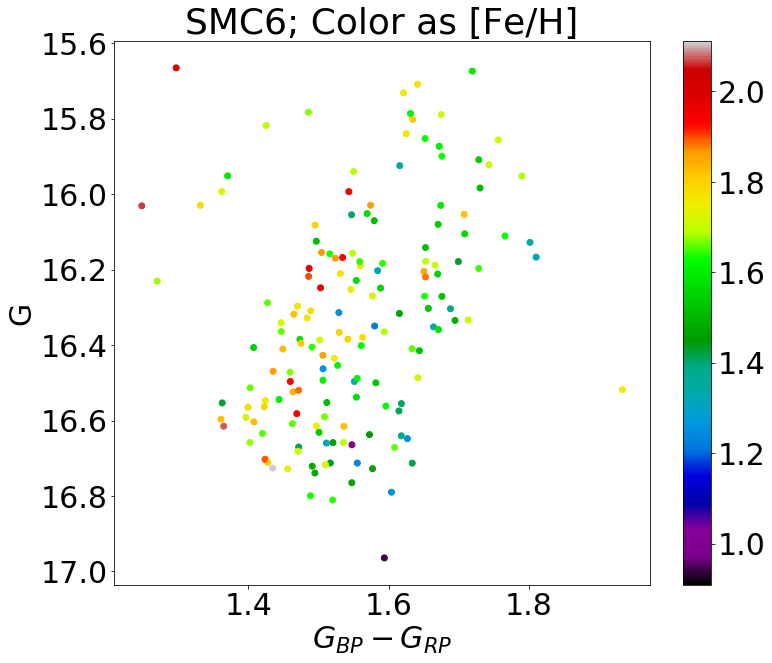

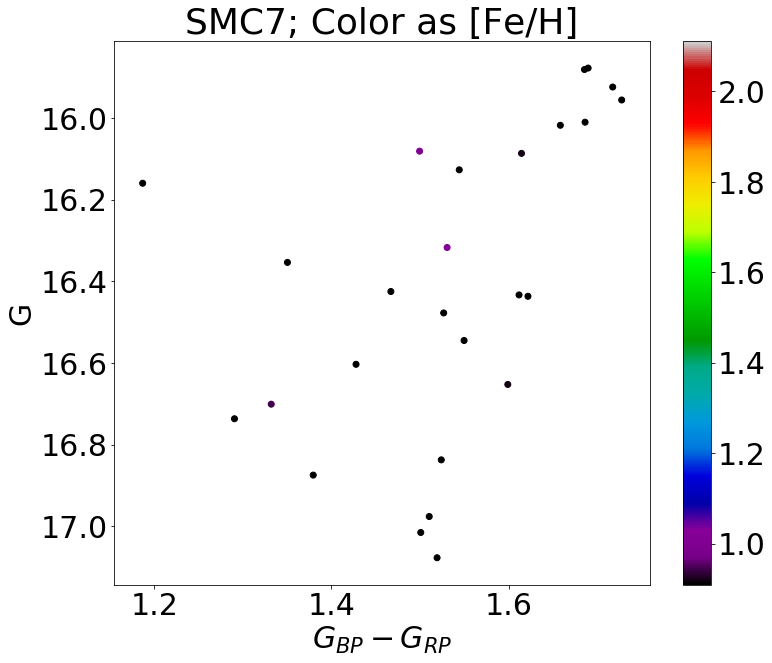

In [168]:
###############################
### Plot Field by Field CMD ###
###############################

for i in range(len(fieldcols)):
    plt.figure(figsize=[12,10])
    plt.scatter(fieldgcols[i],fieldg[i],c=fieldpms[i],cmap='nipy_spectral',
                zorder=2,vmax=max(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)),
                vmin=min(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)))
    plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}; Color as [Fe/H]'.format(fields[i]))
    plt.xlabel(r'$G_{BP} - G_{RP}$')
    plt.ylabel(r'G')

    plt.show()

In [56]:
# ### List of J-K color for each field
# field_bprp = [gaia47['bp_rp'],gaia362['bp_rp'],gaia1['bp_rp'],gaia2['bp_rp'],gaia3['bp_rp'],gaia4['bp_rp'],
#               gaia5['bp_rp'],gaia6['bp_rp'],gaia7['bp_rp']]

# ### List of H for each field
# field_g = [gaia47['phot_g_mean_mag'],gaia362['phot_g_mean_mag'],gaia1['phot_g_mean_mag'],gaia2['phot_g_mean_mag'],
#            gaia3['phot_g_mean_mag'],gaia4['phot_g_mean_mag'],gaia5['phot_g_mean_mag'],gaia6['phot_g_mean_mag'],
#            gaia7['phot_g_mean_mag']]


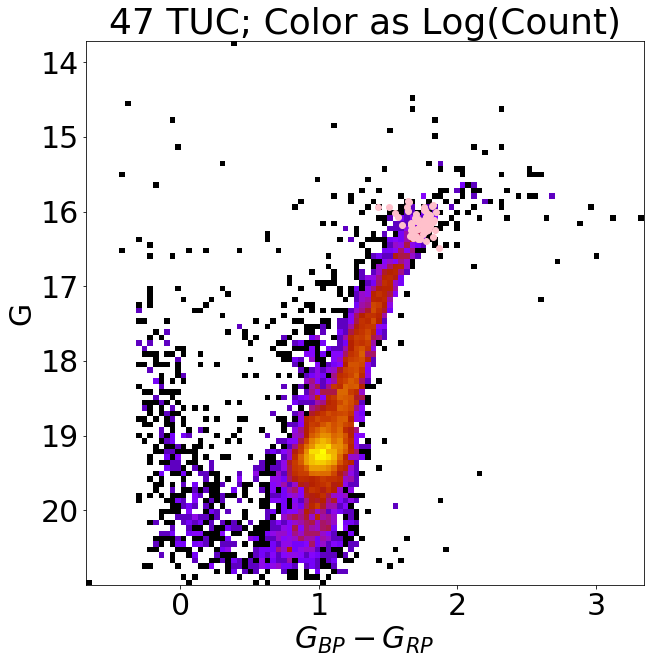

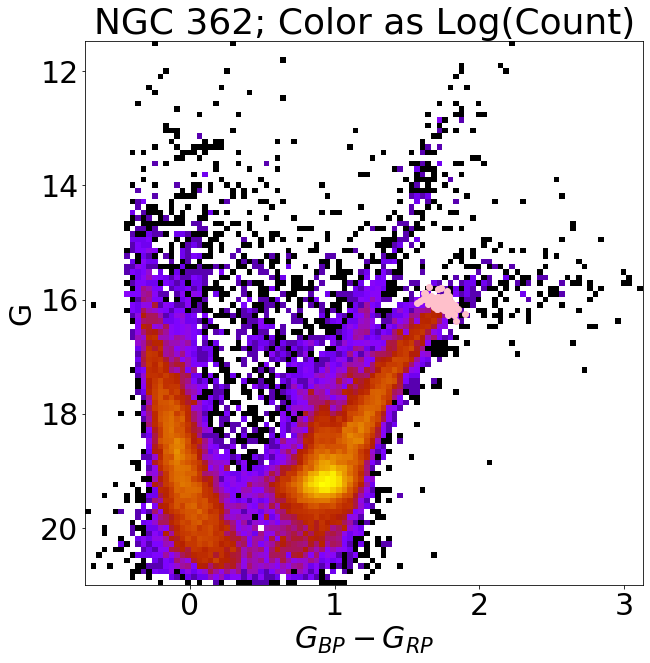

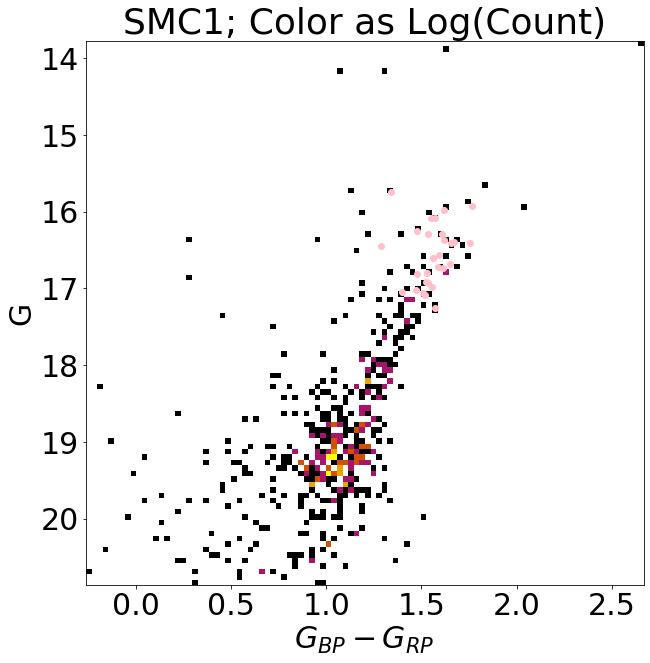

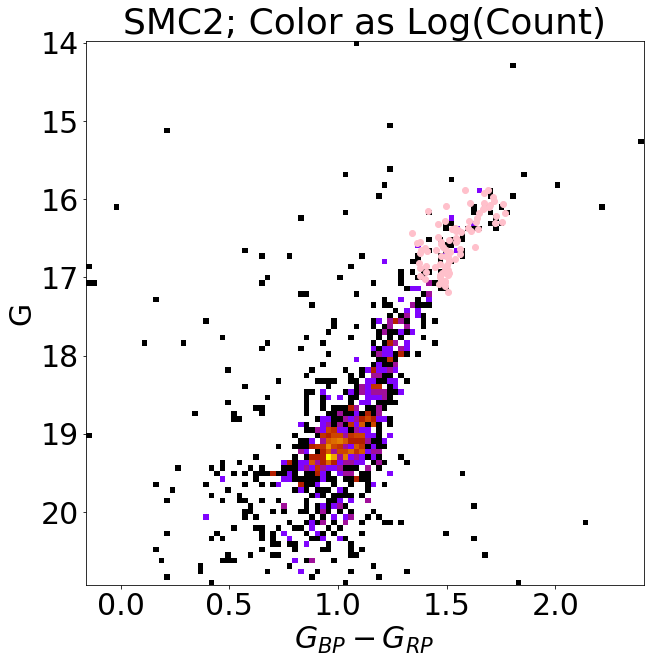

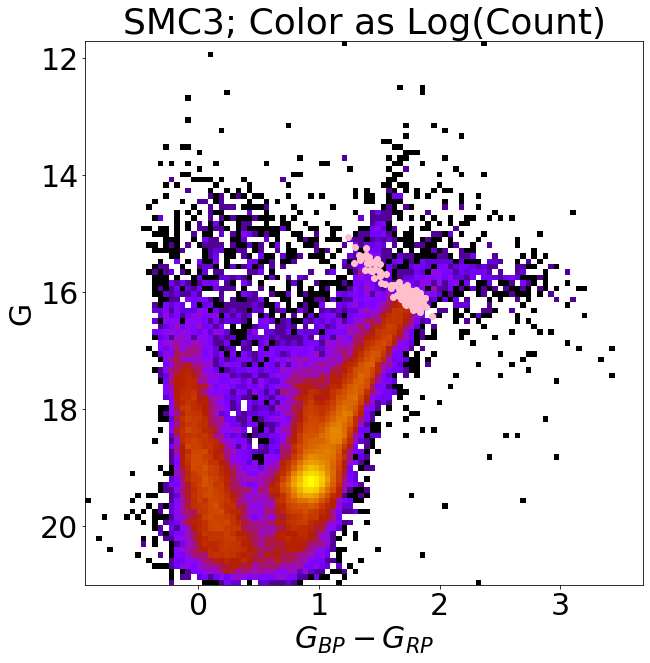

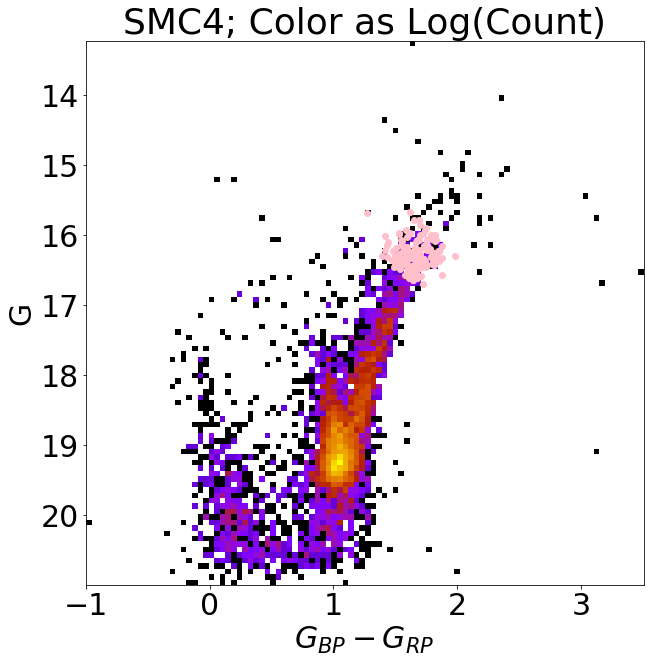

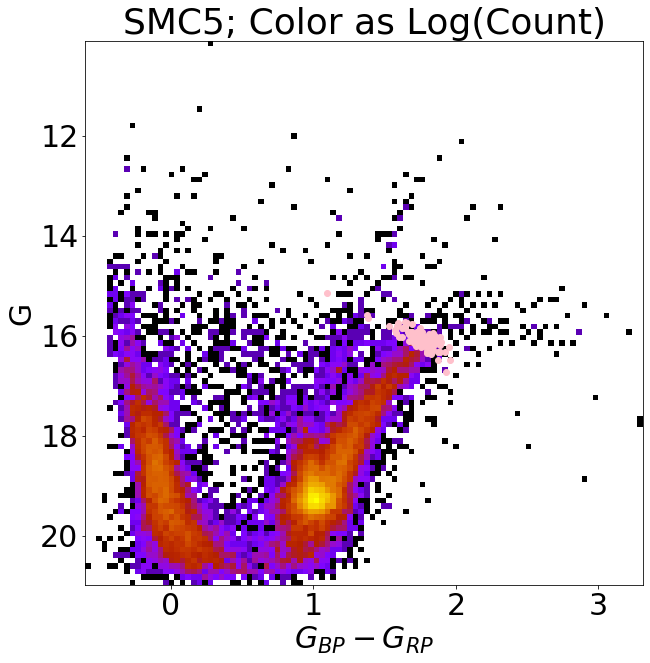

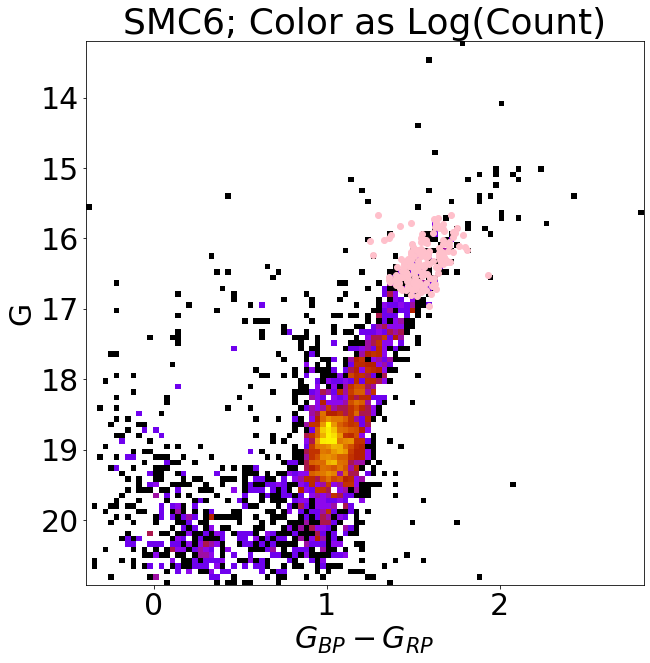

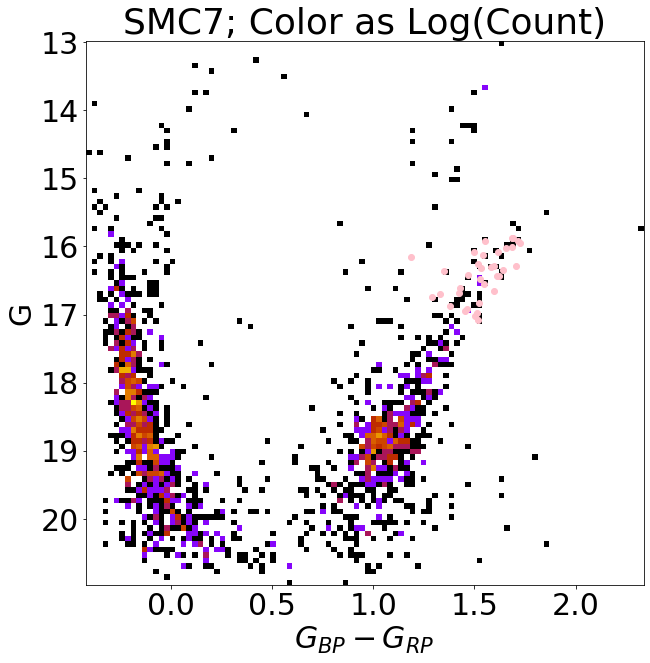

In [273]:
###############################
### Plot Field by Field CMD ###
###############################

from scipy.stats import binned_statistic_2d

fieldfilename = ['47tuc','n362','smc1','smc2','smc3','smc4','smc5','smc6','smc7']

for i in range(len(fieldcols)):
    
    N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
    plt.figure(figsize=[10,10])
    
    plt.imshow(np.log10(N.statistic.T),origin='lower',
           extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
    
    plt.scatter(fieldgcols[i],fieldg[i],c='pink',cmap='nipy_spectral',zorder=2)
    
#     plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}; Color as Log(Count)'.format(fields[i]))
    plt.xlabel(r'$G_{BP} - G_{RP}$')
    plt.ylabel(r'G')

    plt.savefig('gaia{}'.format(fieldfilename[i]),bbox_inches='tight')
    plt.show()

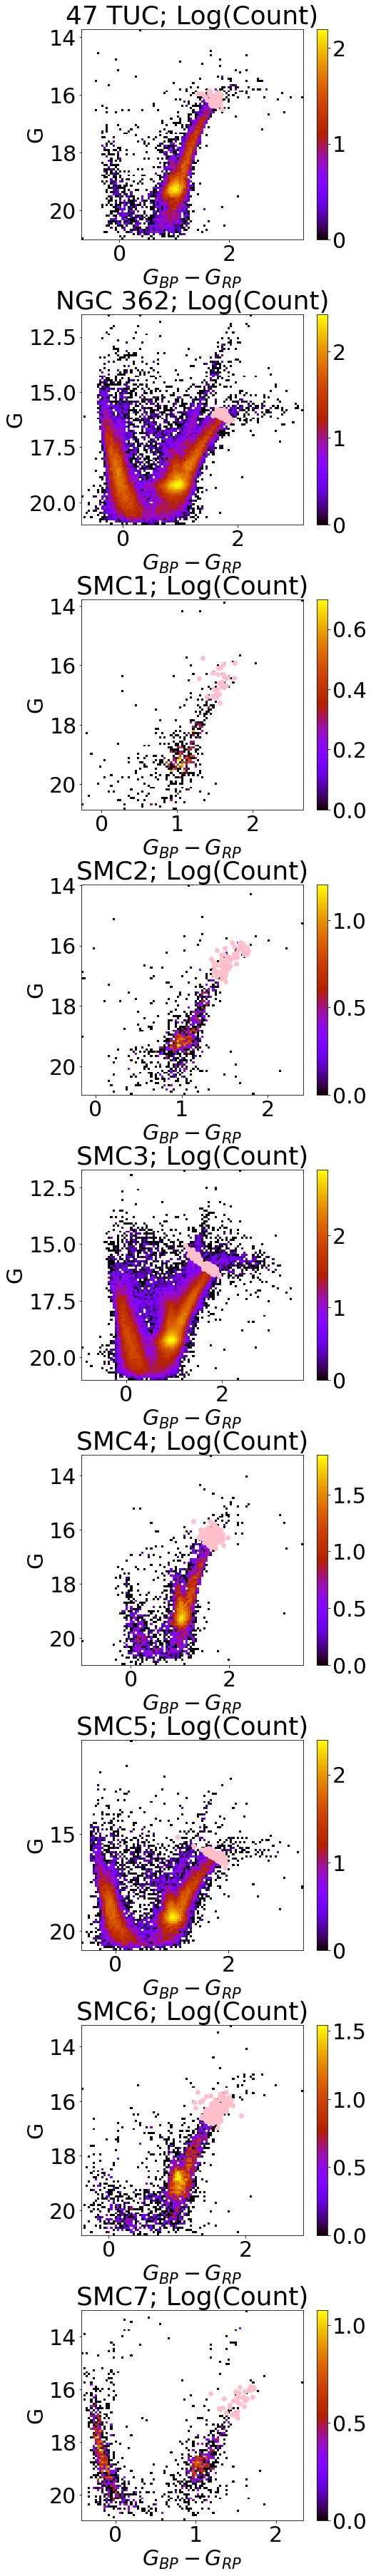

In [283]:
fig,ax = plt.subplots(9,1,figsize=[7,50])

for i in range(len(ax)):
    
    N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
    im = ax[i].imshow(np.log10(N.statistic.T),origin='lower',
                      extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
                      interpolation='nearest',cmap='gnuplot')
    
    plt.colorbar(im,ax=ax[i])
    
    ax[i].scatter(fieldgcols[i],fieldg[i],c='pink',cmap='nipy_spectral',zorder=2)
    
    ax[i].invert_yaxis()
    
#     ax[i].hist(tdist_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k',
#                label='{}'.format(tdist_label[i]))
    
#     ax[i].set_ylim(top=0.07)
#     ax[i].set_xlim(30,135)
    
#     ax[i].legend(loc='upper right')
    ax[i].set_title(r'{}; Log(Count)'.format(fields[i]))
    ax[i].set_xlabel(r'$G_{BP} - G_{RP}$')
    ax[i].set_ylabel(r'G')
    
#     ax[i].axvline(50,ls='--',c='b')
#     ax[i].axvline(60,ls='--',c='b')
#     ax[i].axvline(70,ls='--',c='b')

plt.tight_layout(pad=0.)

plt.savefig('fieldbyfieldCMD.pdf',bbox_inches='tight')
plt.show()

In [284]:
set(smc['FIELD'])

{'47TUC', 'N362', 'SMC1', 'SMC2', 'SMC3', 'SMC4', 'SMC5', 'SMC6', 'SMC7'}

# Field Metallicities

In [174]:
###########################
### Closest Metallicity ###
###########################

smcFE_H = [tuc47['FE_H'],n362['FE_H'],smc1['FE_H'],smc2['FE_H'],smc3['FE_H'],smc4['FE_H'],smc5['FE_H'],
           smc6['FE_H'],smc7['FE_H']]

def near(arr,val):
    '''
    Find the element value of arr closest to the given value
    
    Inputs:
    ------
        arr: array-like object to search
        val: value of interest
        
    Output:
    ------
        out: value in arr closest to the given value (val) 
    '''
    uniq_arr = np.unique(arr)
    idx = np.absolute(uniq_arr-(val)*np.ones(len(uniq_arr))).argmin()
    out = uniq_arr[idx] 
    return out

cl_feh = []
for i in range(len(smcFE_H)):
    cl_feh.append(near(parsec['MH'],np.median(smcFE_H[i])))
    
tot_cl_feh = near(parsec['MH'],np.median(smc_nobloop['FE_H']))

for i in range(9):
    print('{} [Fe/H]: {:.7f} PARSEC: {}'.format(fields[i],np.median(smcFE_H[i]),cl_feh[i]))
    
print('-----')
print('Overall [Fe/H]: {:.7f} PARSEC: {}'.format(np.median(smc_nobloop['FE_H']),tot_cl_feh))

47 TUC [Fe/H]: -1.0650616 PARSEC: -1.05
NGC 362 [Fe/H]: -1.0249616 PARSEC: -1.0
SMC1 [Fe/H]: -1.0770116 PARSEC: -1.1
SMC2 [Fe/H]: -1.1810615 PARSEC: -1.2
SMC3 [Fe/H]: -0.8970466 PARSEC: -0.9
SMC4 [Fe/H]: -1.1073616 PARSEC: -1.1
SMC5 [Fe/H]: -1.0132616 PARSEC: -1.0
SMC6 [Fe/H]: -1.0496116 PARSEC: -1.05
SMC7 [Fe/H]: -1.1504616 PARSEC: -1.15
-----
Overall [Fe/H]: -1.0606616 PARSEC: -1.05


47 TUC [Fe/H]: 0.8046500
NGC 362 [Fe/H]: 0.7015000
SMC1 [Fe/H]: 0.3767000
SMC2 [Fe/H]: 0.4706000
SMC3 [Fe/H]: 0.7555000
SMC4 [Fe/H]: 0.6800000
SMC5 [Fe/H]: 0.7785000
SMC6 [Fe/H]: 0.4885000
SMC7 [Fe/H]: 0.6165000
-----
Overall [Fe/H]: 1.1860000


In [156]:
print(r'Max [Fe/H]: ',max(smc_nobloop['FE_H']))
print(r'Min [Fe/H]: ',min(smc_nobloop['FE_H']))

Max [Fe/H]:  -0.53019154
Min [Fe/H]:  -2.0970616


In [170]:
print(set(parsec9351010['logAge']))
print(set(parsec9351010['MH']))

{9.35, 9.5, 9.55, 9.4, 9.45, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05}
{-0.875, -0.7, -0.525, -1.925, -1.05, -1.4, -1.225, -1.75, -2.1, -1.575}


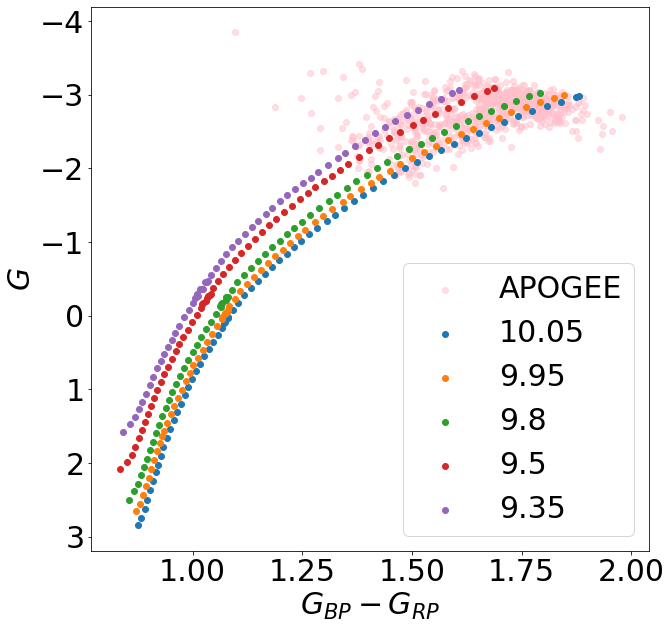

In [294]:
dismod = 18.99

# single_iso = parsecall[np.where((parsecall['MH']==-1.05)&(parsecall['logAge']==9.55))]
iso_1059_8 = parsec9351010[np.where((parsec9351010['MH']==-1.05)&(parsec9351010['logAge']==9.8)&
                                     (parsec9351010['label']==3))]
iso_1059_95 = parsec9351010[np.where((parsec9351010['MH']==-1.05)&(parsec9351010['logAge']==9.95)&
                                     (parsec9351010['label']==3))]
iso_1059_5 = parsec9351010[np.where((parsec9351010['MH']==-1.05)&(parsec9351010['logAge']==9.5)&
                                     (parsec9351010['label']==3))]
iso_1059_35 = parsec9351010[np.where((parsec9351010['MH']==-1.05)&(parsec9351010['logAge']==9.35)&
                                     (parsec9351010['label']==3))]
iso_10510_05 = parsec9351010[np.where((parsec9351010['MH']==-1.05)&(parsec9351010['logAge']==10.05)&
                                     (parsec9351010['label']==3))]

plt.figure(figsize=[10,10])
plt.scatter(smc_nobloop['GAIA_BPMAG']-smc_nobloop['GAIA_RPMAG'],smc_nobloop['GAIA_GMAG']-dismod,
            c='pink',cmap='nipy_spectral',alpha=0.5,zorder=1,label='APOGEE')

plt.scatter(iso_10510_05['G_BPmag']-iso_10510_05['G_RPmag'],iso_10510_05['Gmag'],label='10.05')

plt.scatter(iso_1059_95['G_BPmag']-iso_1059_95['G_RPmag'],iso_1059_95['Gmag'],label='9.95',zorder=2)

plt.scatter(iso_1059_8['G_BPmag']-iso_1059_8['G_RPmag'],iso_1059_8['Gmag'],label='9.8',zorder=2)

plt.scatter(iso_1059_5['G_BPmag']-iso_1059_5['G_RPmag'],iso_1059_5['Gmag'],label='9.5',zorder=2)

plt.scatter(iso_1059_35['G_BPmag']-iso_1059_35['G_RPmag'],iso_1059_35['Gmag'],label='9.35',zorder=2)

# plt.xlim(0.5,2.1)
# plt.ylim(-5,0)

plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$')

plt.legend()

plt.gca().invert_yaxis()
plt.savefig('which_age.pdf',bbox_inches='tight')
plt.show()

In [186]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag','Jmag','Hmag','Ksmag')>

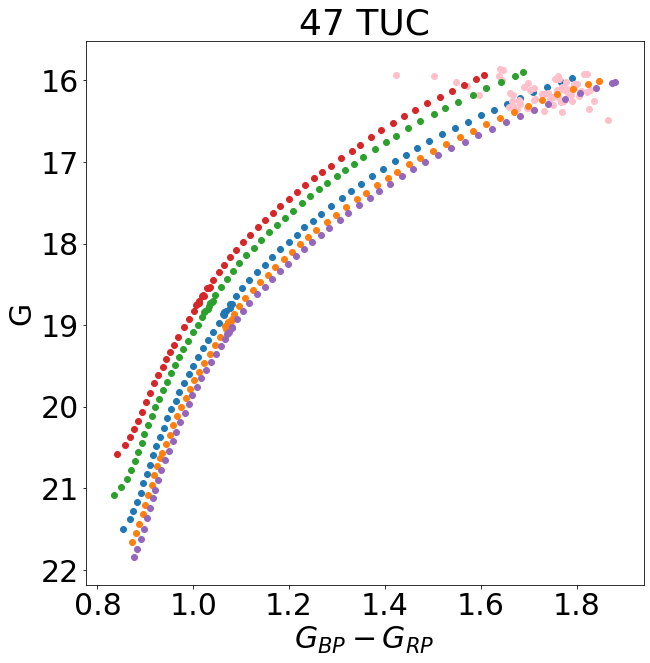

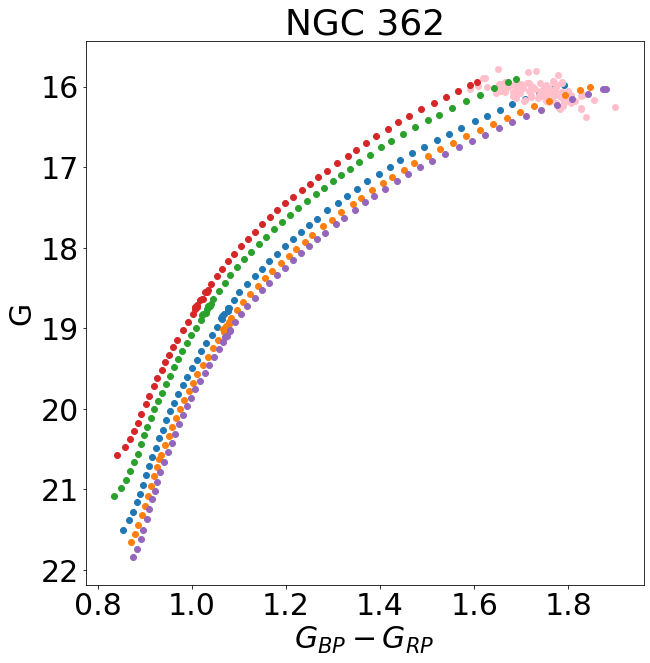

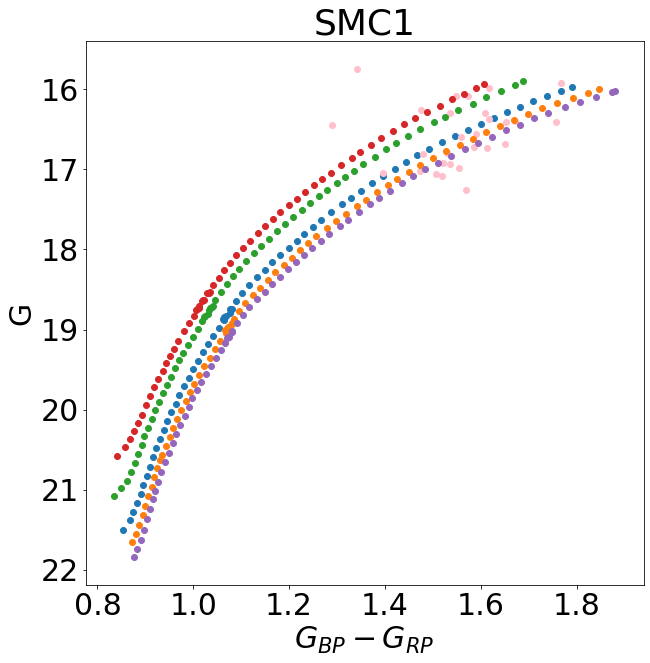

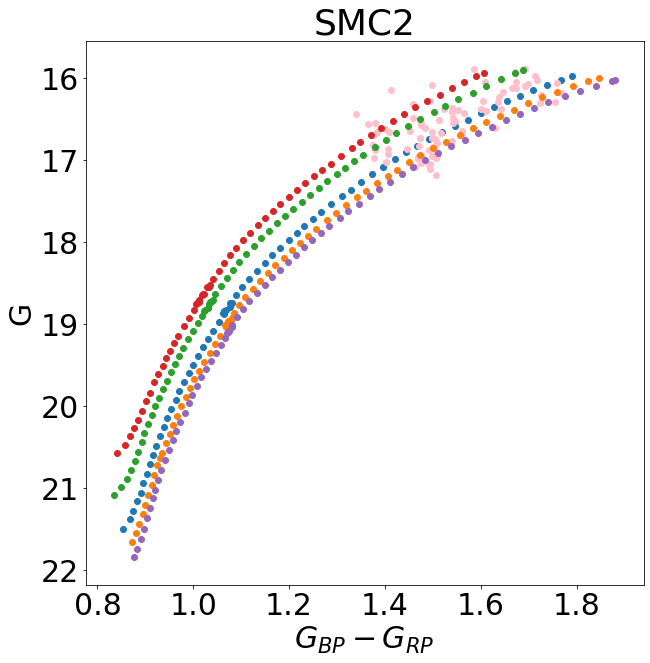

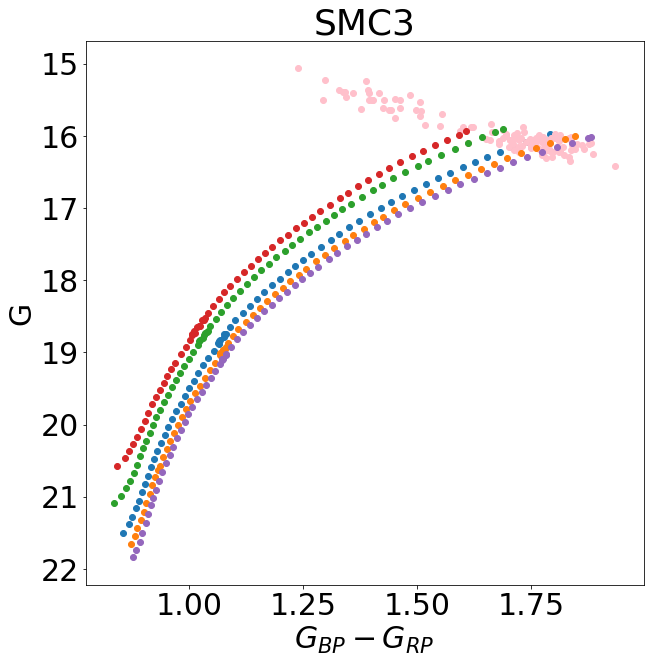

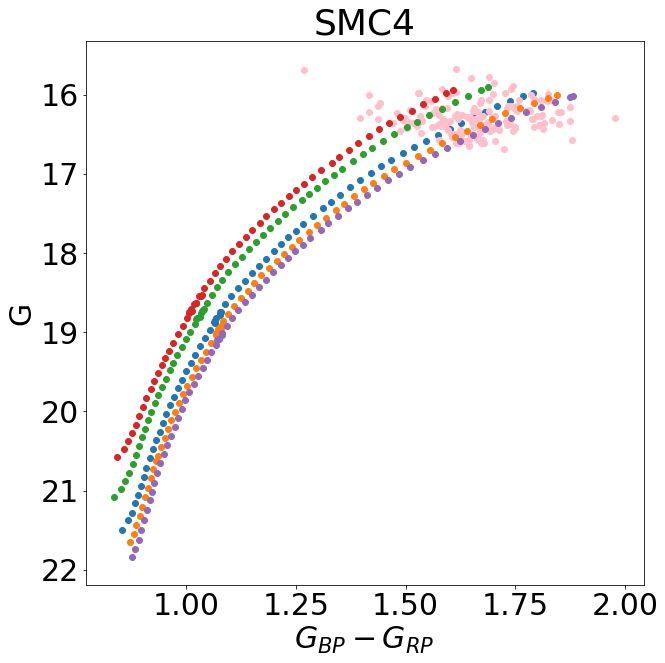

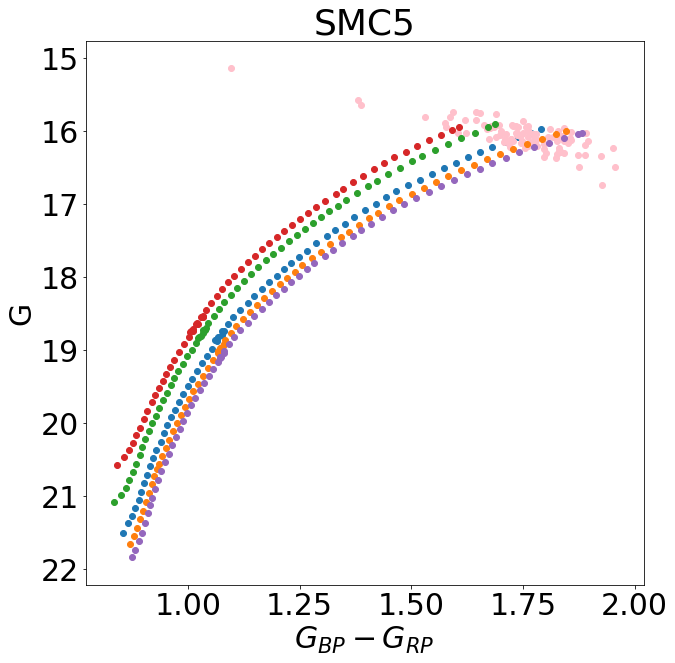

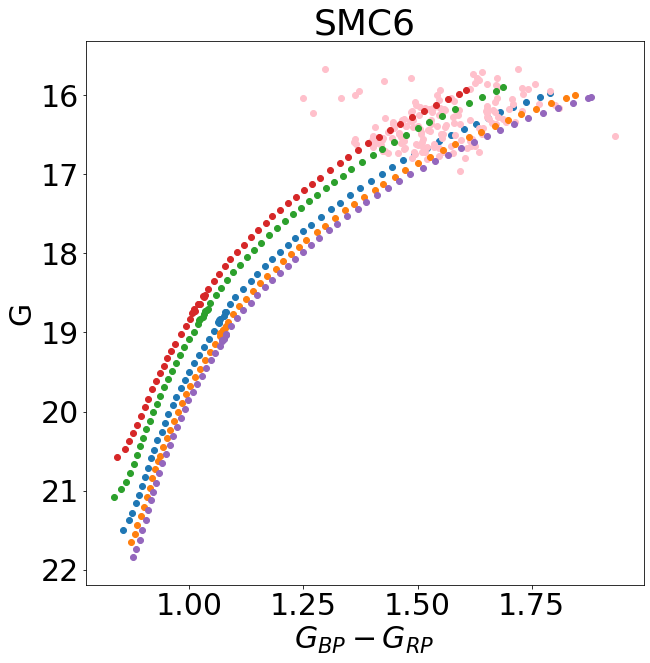

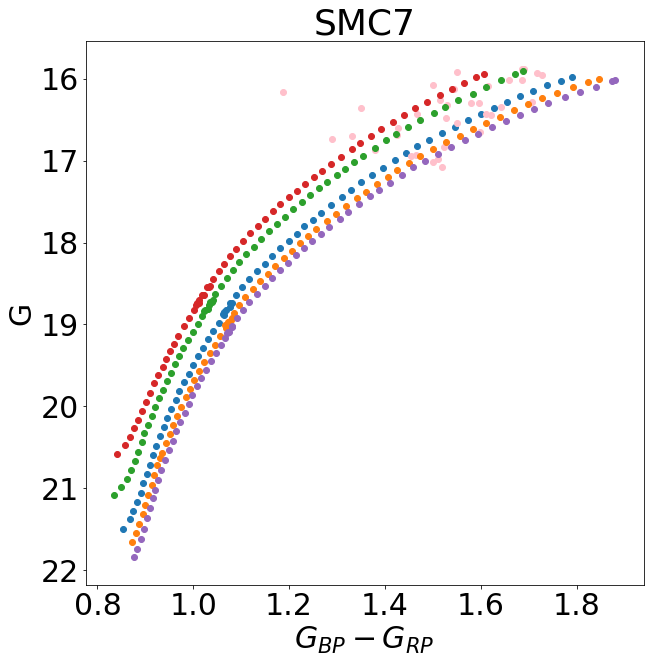

In [184]:
for i in range(len(fieldcols)):
    
#     N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
    plt.figure(figsize=[10,10])
    
#     plt.imshow(np.log10(N.statistic.T),origin='lower',
#            extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
#            interpolation='nearest',cmap='gnuplot')

    plt.scatter(iso_1059_8['G_BPmag']-iso_1059_8['G_RPmag'],iso_1059_8['Gmag']+dismod,zorder=2,label='98')
    plt.scatter(iso_1059_95['G_BPmag']-iso_1059_95['G_RPmag'],iso_1059_95['Gmag']+dismod,zorder=3,label='975')
    plt.scatter(iso_1059_5['G_BPmag']-iso_1059_5['G_RPmag'],iso_1059_5['Gmag']+dismod,zorder=4,label='95')
    plt.scatter(iso_1059_35['G_BPmag']-iso_1059_35['G_RPmag'],iso_1059_35['Gmag']+dismod,zorder=5,label='935')
    plt.scatter(iso_10510_05['G_BPmag']-iso_10510_05['G_RPmag'],iso_10510_05['Gmag']+dismod,zorder=6,label='1005')
    
    plt.scatter(fieldgcols[i],fieldg[i],c='pink',cmap='nipy_spectral',zorder=2)
    
#     plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}'.format(fields[i]))
    plt.xlabel(r'$G_{BP} - G_{RP}$')
    plt.ylabel(r'G')

    plt.show()

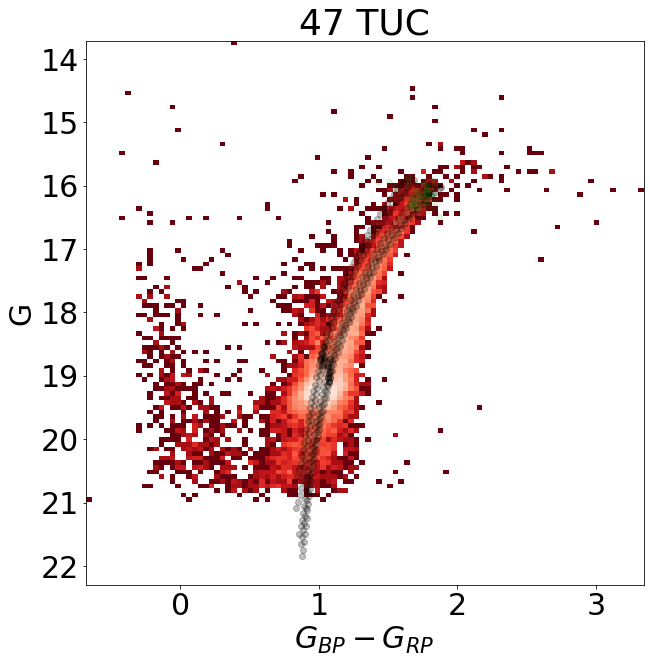

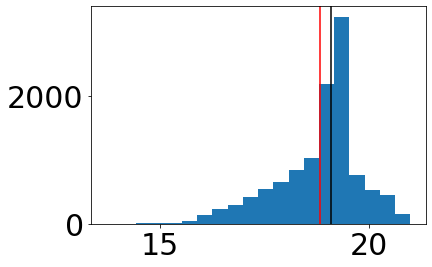

22.848431121826174


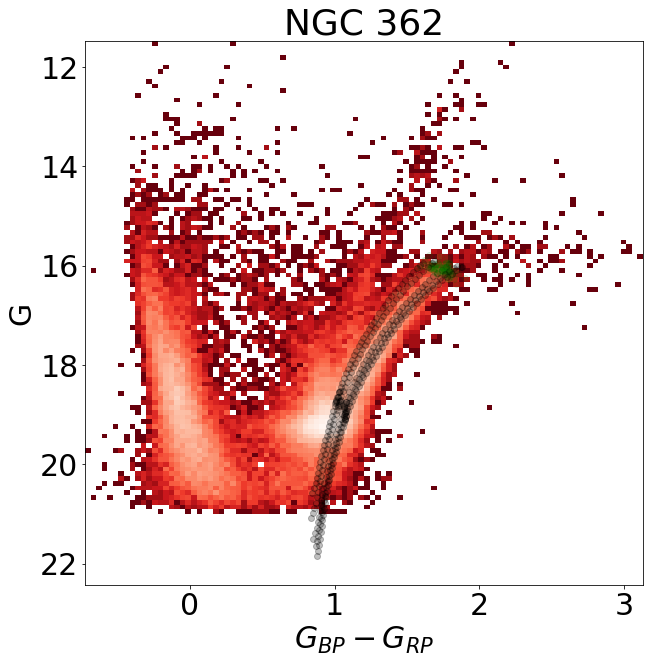

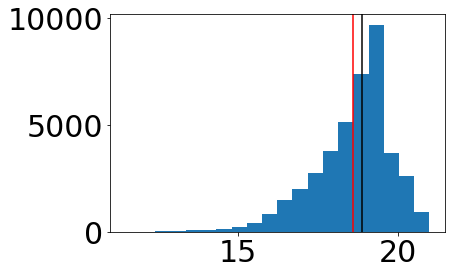

22.62635661315918


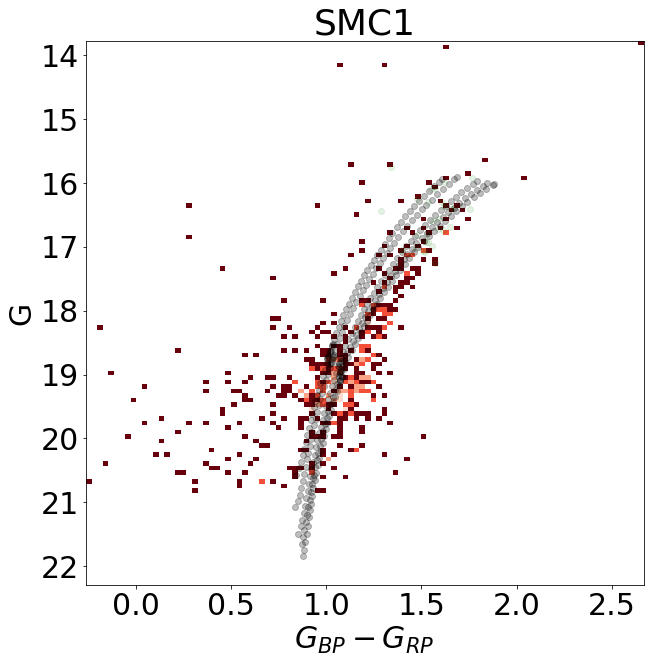

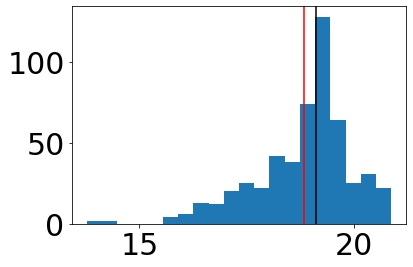

22.847652923583986


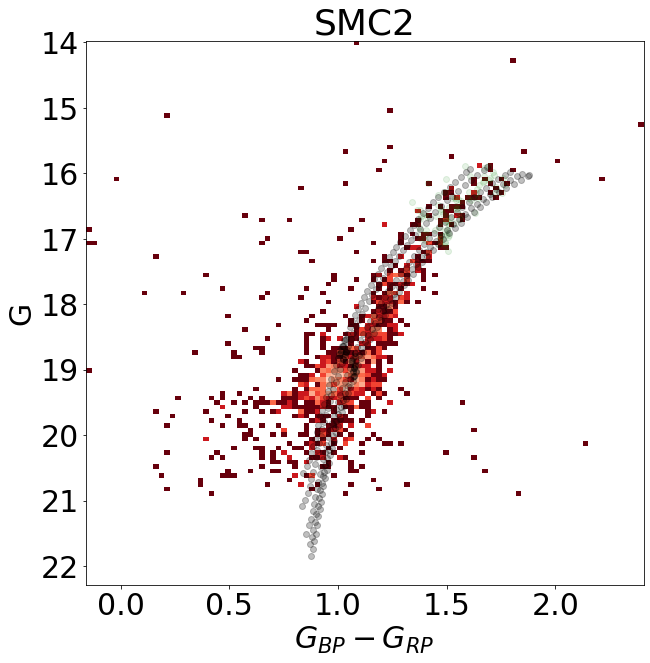

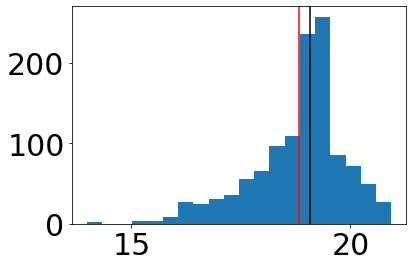

22.806303512573244


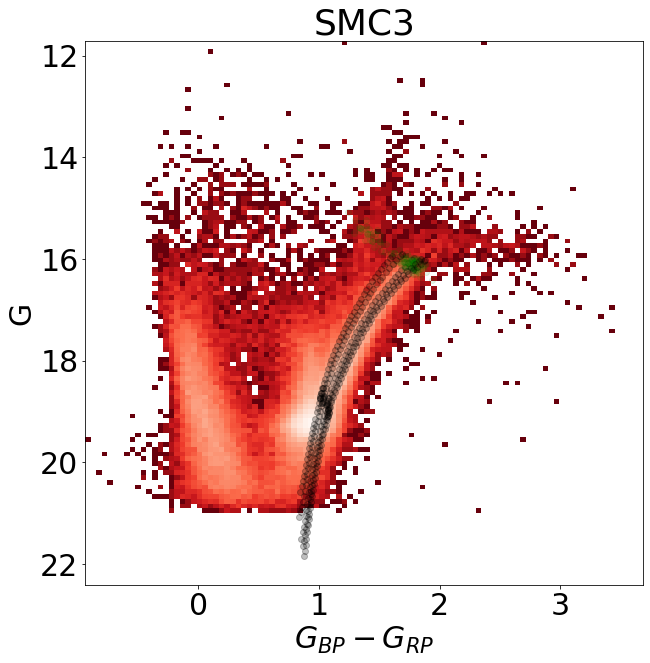

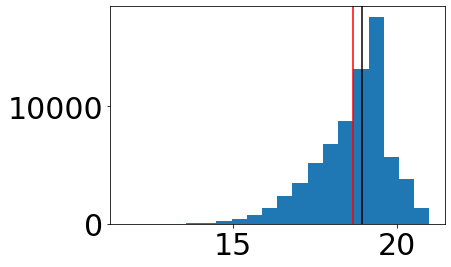

22.681812774658205


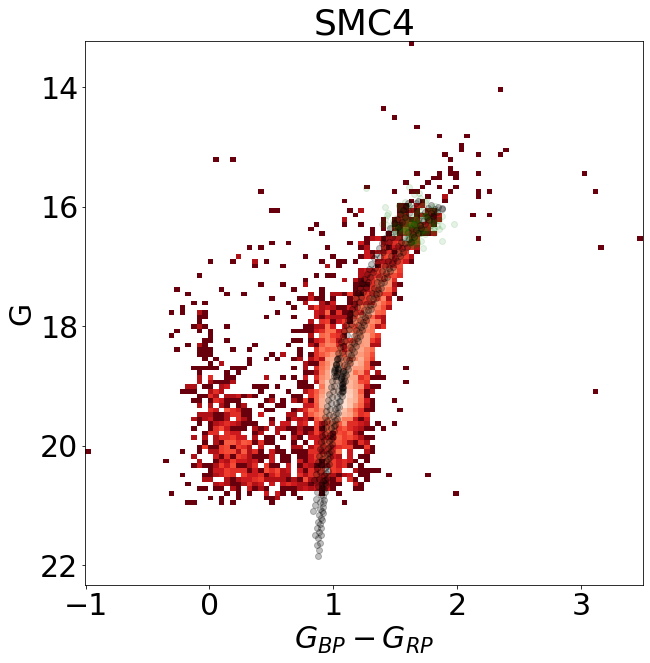

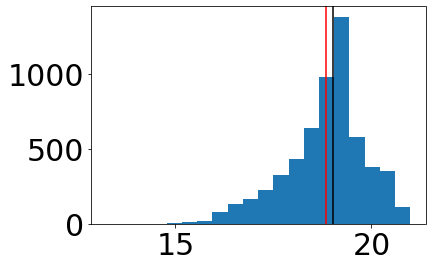

22.74974871826172


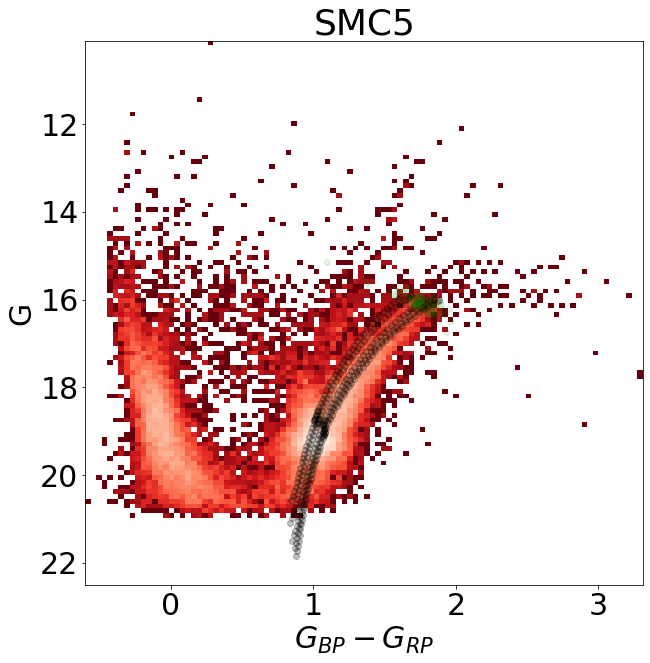

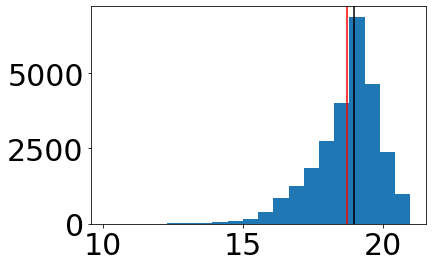

22.71720362854004


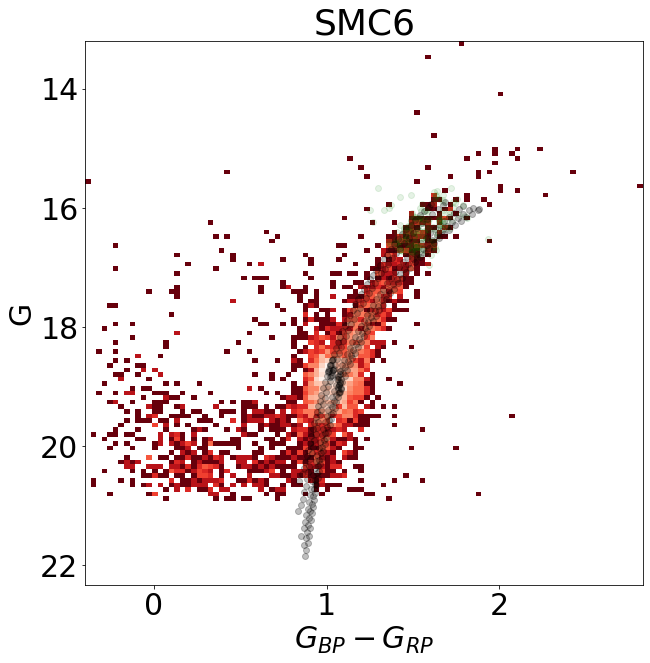

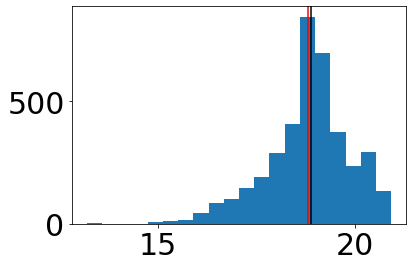

22.626839172363283


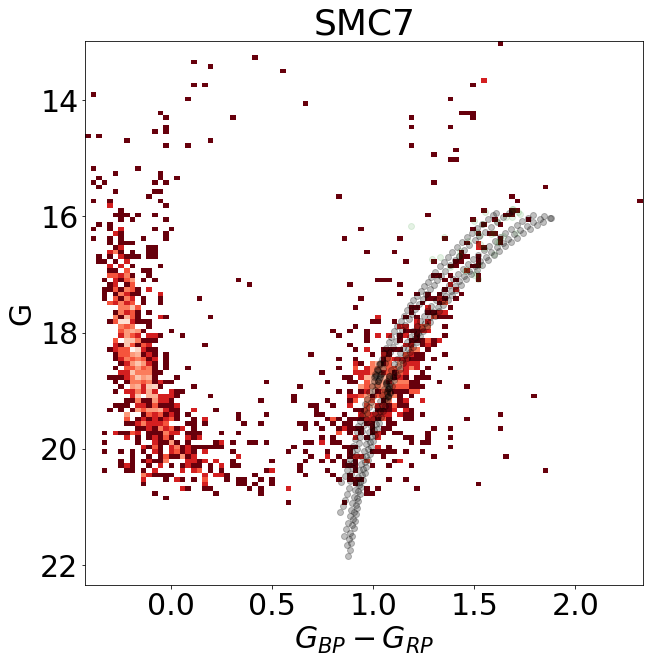

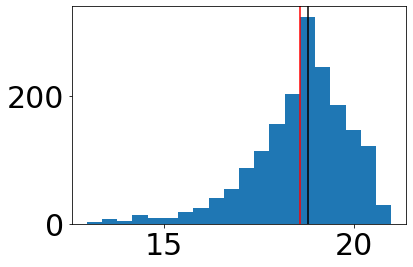

22.51342059326172


In [228]:
for i in range(len(fieldcols)):
    
    N = binned_statistic_2d(x=field_bprp[i],y=field_g[i],values=field_bprp[i],statistic='count',bins=100)
    
    plt.figure(figsize=[10,10])
    
    plt.imshow(np.log10(N.statistic.T),origin='lower',
           extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='Reds_r')

    plt.scatter(iso_1059_8['G_BPmag']-iso_1059_8['G_RPmag'],iso_1059_8['Gmag']+dismod,zorder=2,label='98',
                c='k',alpha=0.25)
    plt.scatter(iso_1059_95['G_BPmag']-iso_1059_95['G_RPmag'],iso_1059_95['Gmag']+dismod,zorder=3,label='975',
                c='k',alpha=0.25)
    plt.scatter(iso_1059_5['G_BPmag']-iso_1059_5['G_RPmag'],iso_1059_5['Gmag']+dismod,zorder=4,label='95',
                c='k',alpha=0.25)
    plt.scatter(iso_1059_35['G_BPmag']-iso_1059_35['G_RPmag'],iso_1059_35['Gmag']+dismod,zorder=5,label='935',
                c='k',alpha=0.25)
    plt.scatter(iso_10510_05['G_BPmag']-iso_10510_05['G_RPmag'],iso_10510_05['Gmag']+dismod,zorder=6,label='1005',
                c='k',alpha=0.25)
    
    plt.scatter(fieldgcols[i],fieldg[i],c='green',cmap='nipy_spectral',zorder=2,alpha=0.1)
    
#     plt.colorbar()
    plt.gca().invert_yaxis()

    plt.title(r'{}'.format(fields[i]))
    plt.xlabel(r'$G_{BP} - G_{RP}$')
    plt.ylabel(r'G')

    plt.show()
    
    plt.hist(field_g[i],bins=20)
    plt.axvline(np.nanmedian(field_g[i]),color='k')
    plt.axvline(np.nanmean(field_g[i]),color='r')
    plt.show()
    
    print(np.nanmedian(field_g[i])+3.737)

62230.911715228285
15725.701197773717


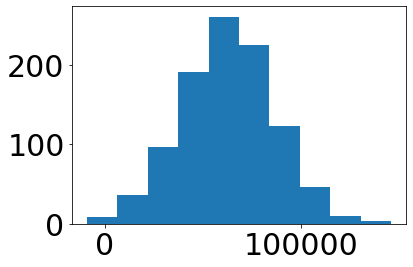

In [216]:
plt.hist(util.add_noise(62810*np.ones(1000),23000,distribution='normal'))
print(np.median(util.add_noise(62810*np.ones(1000),23000,distribution='normal')))
print(util.mad(util.add_noise(62810*np.ones(1000),23000,distribution='normal')))

18.820932874955187
1.0039458806029626


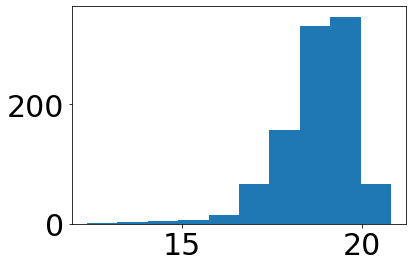

In [215]:
plt.hist((5*np.log10(util.add_noise(62810*np.ones(1000),23000,distribution='normal'))-5))
print(np.nanmean((5*np.log10(util.add_noise(62810*np.ones(1000),23000,distribution='normal'))-5)))
print(np.nanstd((5*np.log10(util.add_noise(62810*np.ones(1000),23000,distribution='normal'))-5)))

(array([24., 61., 73., 58., 33.,  8.,  1.,  0.,  0.,  1.]),
 array([0.0495    , 0.1496    , 0.24970001, 0.34980002, 0.4499    ,
        0.55      , 0.6501    , 0.75020003, 0.8503    , 0.95040005,
        1.0505    ], dtype=float32),
 <a list of 10 Patch objects>)

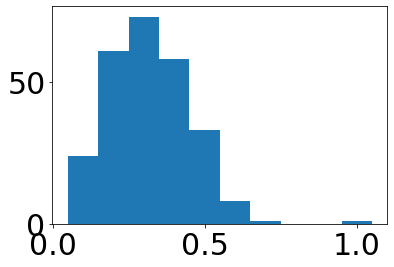

In [234]:
# plt.hist(smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_A_G_VAL'])

plt.hist(smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_E_BP_MIN_RP_VAL'])

A_G = m*E(BP-RP) + b:   
2.014 x + 0.0177


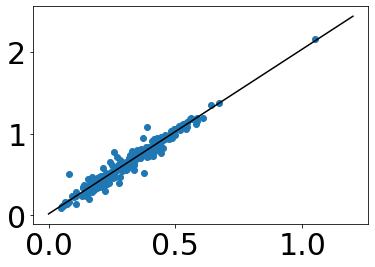

In [257]:
###############################
### Determine Reddening Law ###
###############################

'''A_G = m*E(BP-RP) + b'''

### APOGEE (GAIA)
z = np.polyfit(smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_E_BP_MIN_RP_VAL'], 
               smc[np.where(smc['GAIA_A_G_VAL']!=-9999.0)]['GAIA_A_G_VAL'], 1)
p = np.poly1d(z)

print('A_G = m*E(BP-RP) + b: ',p)

In [266]:
smcA_G = [tuc47['GAIA_A_G_VAL'],n362['GAIA_A_G_VAL'],smc1['GAIA_A_G_VAL'],smc2['GAIA_A_G_VAL'],
          smc3['GAIA_A_G_VAL'],smc4['GAIA_A_G_VAL'],smc5['GAIA_A_G_VAL'],smc6['GAIA_A_G_VAL'],
          smc7['GAIA_A_G_VAL']]

for i in range(9):
    cln = np.where(smcA_G[i]!=-9999.0)
    print('{} A_G: {:.4f} Cioni {:.4f}'.format(fields[i],np.nanmedian(smcA_G[i][cln]),
                                               18.99+np.nanmedian(smcA_G[i][cln])))
    
print('-----')
cln_tot = np.where(smc_nobloop['GAIA_A_G_VAL'][i]!=-9999.0)
print('Overall A_G: {:.4f} Cioni {:.4f}'.format(np.nanmedian(smc_nobloop['GAIA_A_G_VAL'][cln_tot]),
                                                18.99+np.nanmedian(smc_nobloop['GAIA_A_G_VAL'][cln_tot])))

47 TUC A_G: 0.8047 Cioni 19.7947
NGC 362 A_G: 0.7015 Cioni 19.6915
SMC1 A_G: 0.3767 Cioni 19.3667
SMC2 A_G: 0.4706 Cioni 19.4606
SMC3 A_G: 0.7555 Cioni 19.7455
SMC4 A_G: 0.6800 Cioni 19.6700
SMC5 A_G: 0.7785 Cioni 19.7685
SMC6 A_G: 0.4885 Cioni 19.4785
SMC7 A_G: 0.6165 Cioni 19.6065
-----
Overall A_G: 1.1860 Cioni 20.1760


(array([1966., 4085., 3223., 1249.,  439.,  268.,  153.,   47.,    6.,
          11.]),
 array([0.006     , 0.1775    , 0.34899998, 0.5205    , 0.692     ,
        0.8635    , 1.035     , 1.2064999 , 1.378     , 1.5495    ,
        1.721     ], dtype=float32),
 <a list of 10 Patch objects>)

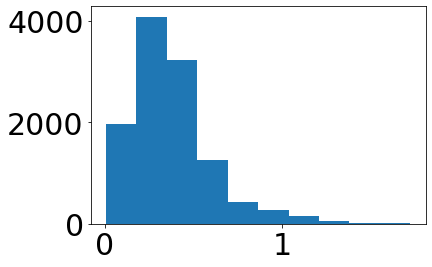

In [253]:
cln_ag = np.where(np.isfinite(smc_gaia['a_g_val'])==True)
plt.hist(smc_gaia[cln_ag]['e_bp_min_rp_val'])

In [227]:
# def gaia22mass(g,bp_rp,band='K'):
#     '''
#     Convert GAIA magnitudes to 2MASS magnitudes using G and G_{RP} - G_{BP} using
        
#         mag = G - c - b*(G_{RP} - G_{BP}) - a*(G_{RP} - G_{BP})**2
        
#     Inputs:
#     ------
#         g: GAIA G magnitude 
#         bp_rp: GAIA G_{RP} - G_{BP} color
#         band: one of the 2MASS passbands
    
#     output:
#     ------
#         mag: 2MASS magnitude calculate from GAIA photometry
#     '''
    
#     if band == 'J':
#         mag = g - (-0.01883) + (1.394)*bp_rp - (-0.07893)*(bp_rp**2)
        
#     if band == 'H':
#         mag = g - (-0.1621) + (1.968)*bp_rp - (-0.1328)*(bp_rp**2)
        
#     if band == 'K':
#         mag = g - (-0.1885) + (2.092)*bp_rp - (-0.1345)*(bp_rp**2)
    
#     return mag

In [225]:
# gaiaJ = gaia22mass(smc_gaia['phot_g_mean_mag'],smc_gaia['bp_rp'],band='J')
# gaiaH = gaia22mass(smc_gaia['phot_g_mean_mag'],smc_gaia['bp_rp'],band='H')
# gaiaK = gaia22mass(smc_gaia['phot_g_mean_mag'],smc_gaia['bp_rp'],band='K')

In [226]:
# for i in range(len(field_g)):
#     j = gaia22mass(field_g[i],field_bprp[i],band='J')
#     k = gaia22mass(field_g[i],field_bprp[i],band='K')
#     h = gaia22mass(field_g[i],field_bprp[i],band='H')
    
#     N = binned_statistic_2d(x=j-k,y=h,values=field_bprp[i],statistic='count',bins=100)
    
#     plt.figure(figsize=[10,10])
    
#     plt.imshow(np.log10(N.statistic.T),origin='lower',
#            extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],aspect='auto',
#            interpolation='nearest',cmap='Reds_r')
    
#     plt.scatter(fieldcols[i],fieldh[i],c='green',cmap='nipy_spectral',zorder=2)
    
# #     plt.colorbar()
#     plt.gca().invert_yaxis()

#     plt.title(r'{}'.format(fields[i]))
#     plt.xlabel(r'$G_{BP} - G_{RP}$')
#     plt.ylabel(r'G')

#     plt.show()

In [47]:
#################
### Red Clump ###
#################

rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

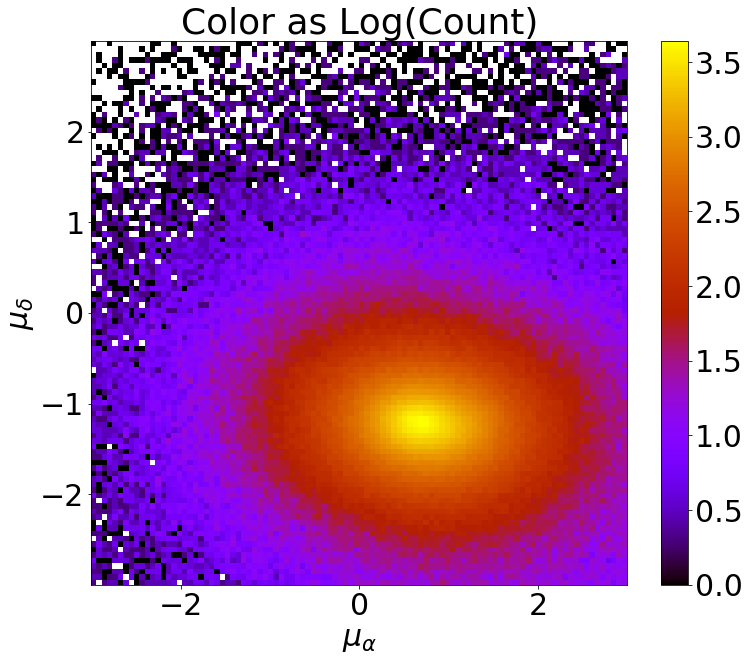

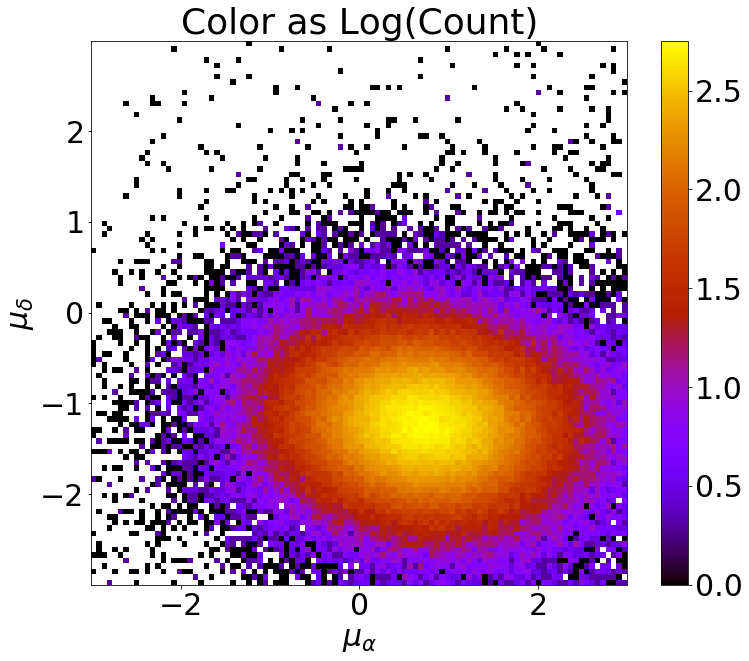

In [48]:
from scipy.stats import binned_statistic_2d

Npm = binned_statistic_2d(x=smc_gaia['pmra'],y=smc_gaia['pmdec'],
                        values=smc_gaia['pmra'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Npm.statistic.T),origin='lower',
           extent=[Npm.x_edge[0],Npm.x_edge[-1],Npm.y_edge[0],Npm.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

# plt.axhline(np.nanmedian(np.tan(np.radians(phi0))),ls='--',lw=3.0,c='deepskyblue')

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$\mu_{\alpha}$')
plt.ylabel(r'$\mu_{\delta}$')

plt.show()

Npm_rc = binned_statistic_2d(x=rc_gaia['pmra'],y=rc_gaia['pmdec'],
                        values=rc_gaia['pmra'],statistic='count',bins=100)

plt.figure(figsize=[12,10])
plt.imshow(np.log10(Npm_rc.statistic.T),origin='lower',
           extent=[Npm_rc.x_edge[0],Npm_rc.x_edge[-1],Npm_rc.y_edge[0],Npm_rc.y_edge[-1]],aspect='auto',
           interpolation='nearest',cmap='gnuplot')
plt.colorbar()

# plt.axhline(np.nanmedian(np.tan(np.radians(phi0))),ls='--',lw=3.0,c='deepskyblue')

plt.title(r'Color as Log(Count)')
plt.xlabel(r'$\mu_{\alpha}$')
plt.ylabel(r'$\mu_{\delta}$')

plt.show()

In [49]:
print('RC: ',(np.mean(rc_gaia['pmra']),np.mean(rc_gaia['pmdec'])))
print('SMC: ',(np.mean(smc_gaia['pmra']),np.mean(smc_gaia['pmdec'])))

RC:  (0.6969059577592897, -1.2081500218721217)
SMC:  (0.7064598968426914, -1.1900498507802613)


In [50]:
np.log(np.sqrt(smc_gaia['pmra']**2+smc_gaia['pmdec']**2))

array([ 0.23033804,  0.19555322,  0.18581927, ...,  0.20431825,
        0.28944721, -0.60454251])

(array([  5.,   3.,  32.,  88., 179., 198., 143., 120.,  65.,  13.]),
 array([-0.54676775, -0.4625635 , -0.37835925, -0.29415501, -0.20995076,
        -0.12574651, -0.04154227,  0.04266198,  0.12686623,  0.21107048,
         0.29527472]),
 <a list of 10 Patch objects>)

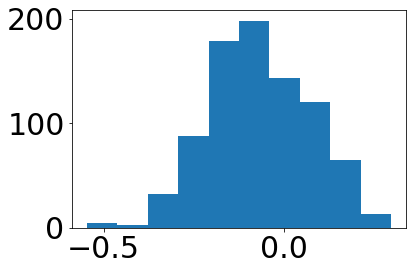

In [59]:
plt.hist(np.log(np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)/
       np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))))

(array([ 13.,  65., 120., 143., 198., 179.,  88.,  32.,   3.,   5.]),
 array([-0.29527472, -0.21107048, -0.12686623, -0.04266198,  0.04154227,
         0.12574651,  0.20995076,  0.29415501,  0.37835925,  0.4625635 ,
         0.54676775]),
 <a list of 10 Patch objects>)

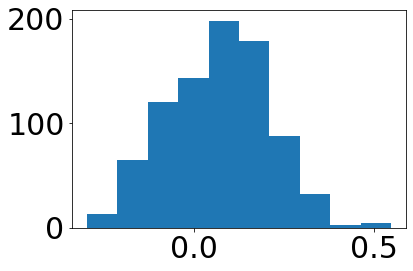

In [67]:
plt.hist(np.log(np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
                np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)))

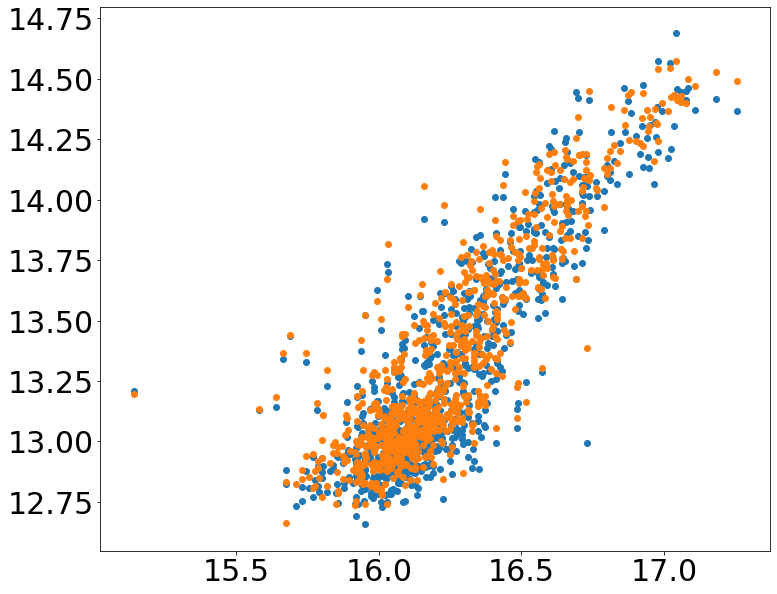

In [149]:
gaiak2mass = (0.1885-2.092*(smc_nobloop['GAIA_BPMAG']-smc_nobloop['GAIA_RPMAG'])+
              0.1345*(smc_nobloop['GAIA_BPMAG']-smc_nobloop['GAIA_RPMAG'])**2+smc_nobloop['GAIA_GMAG'])
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['GAIA_GMAG'],smc_nobloop['K'])
plt.scatter(smc_nobloop['GAIA_GMAG'],gaiak2mass)
# plt.plot([15,18],[15,18],c='k',ls='--')

In [168]:
# rc_cen = np.where((rc_gaia['ra']>12.68333333)&(rc_gaia['ra']<13.68333333)&
#                   (rc_gaia['dec']>-73.32833333)&(rc_gaia['dec']<-72.32833333))

In [84]:
east = Table(np.hstack([smc4,smc5,smc6,smc7]))
west = Table(np.hstack([tuc47,smc1,smc2]))
center = Table(np.hstack([n362,smc3]))

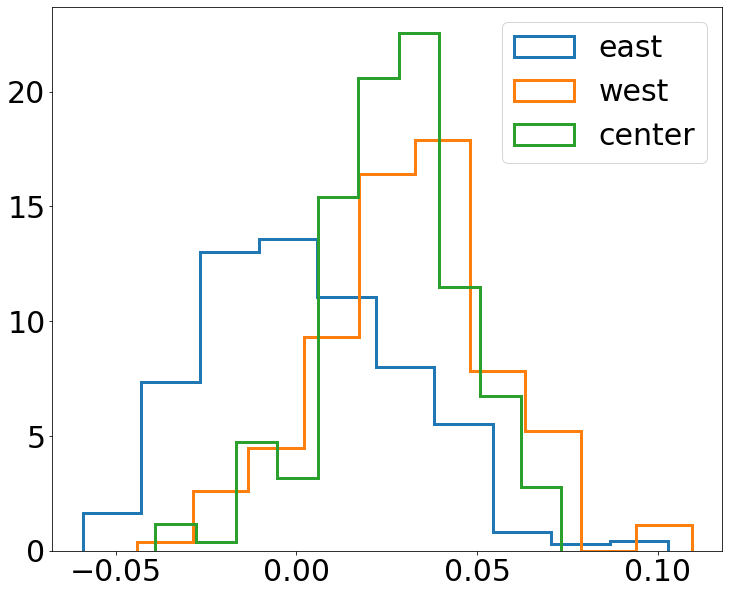

In [91]:
plt.figure(figsize=[12,10])
# plt.hist(np.log(np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
#                 np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2)),density=True,histtype='step',
#          label='All',lw=3.0)

plt.hist((1/5.)*np.log(np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
                np.sqrt(east['GAIA_PMRA']**2+east['GAIA_PMDEC']**2)),density=True,histtype='step',label='east',
         lw=3.0)

plt.hist((1/5.)*np.log(np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
                np.sqrt(west['GAIA_PMRA']**2+west['GAIA_PMDEC']**2)),density=True,histtype='step',label='west',
         lw=3.0)

plt.hist((1/5.)*np.log(np.mean(np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2))/
                np.sqrt(center['GAIA_PMRA']**2+center['GAIA_PMDEC']**2)),density=True,histtype='step',
         label='center',lw=3.0)

plt.legend()


In [189]:
def mag_dist(m,m0):
    '''
    Calcuate distance from difference in magnitiude
    
    $d = d_0 \times 10^{(m - m_0)/5}$
    
    Inputs:
    ------
        m: magnitude of star
        m0: reference magnitude
    
    Output:
    ------
        d: distance in kpc
    '''
    d = (10**(np.subtract(m,m0)/5.+1+18.99/5.))/1000. #distance to smc 10**(1+18.99/5.) pc = 62.81 kpc
    return d

In [190]:
dist47 = mag_dist(tuc47['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist362 = mag_dist(n362['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist1 = mag_dist(smc1['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist2 = mag_dist(smc2['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist3 = mag_dist(smc3['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist4 = mag_dist(smc4['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist5 = mag_dist(smc5['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist6 = mag_dist(smc6['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))
dist7 = mag_dist(smc7['GAIA_GMAG'],np.median(rc_gaia['phot_g_mean_mag']))

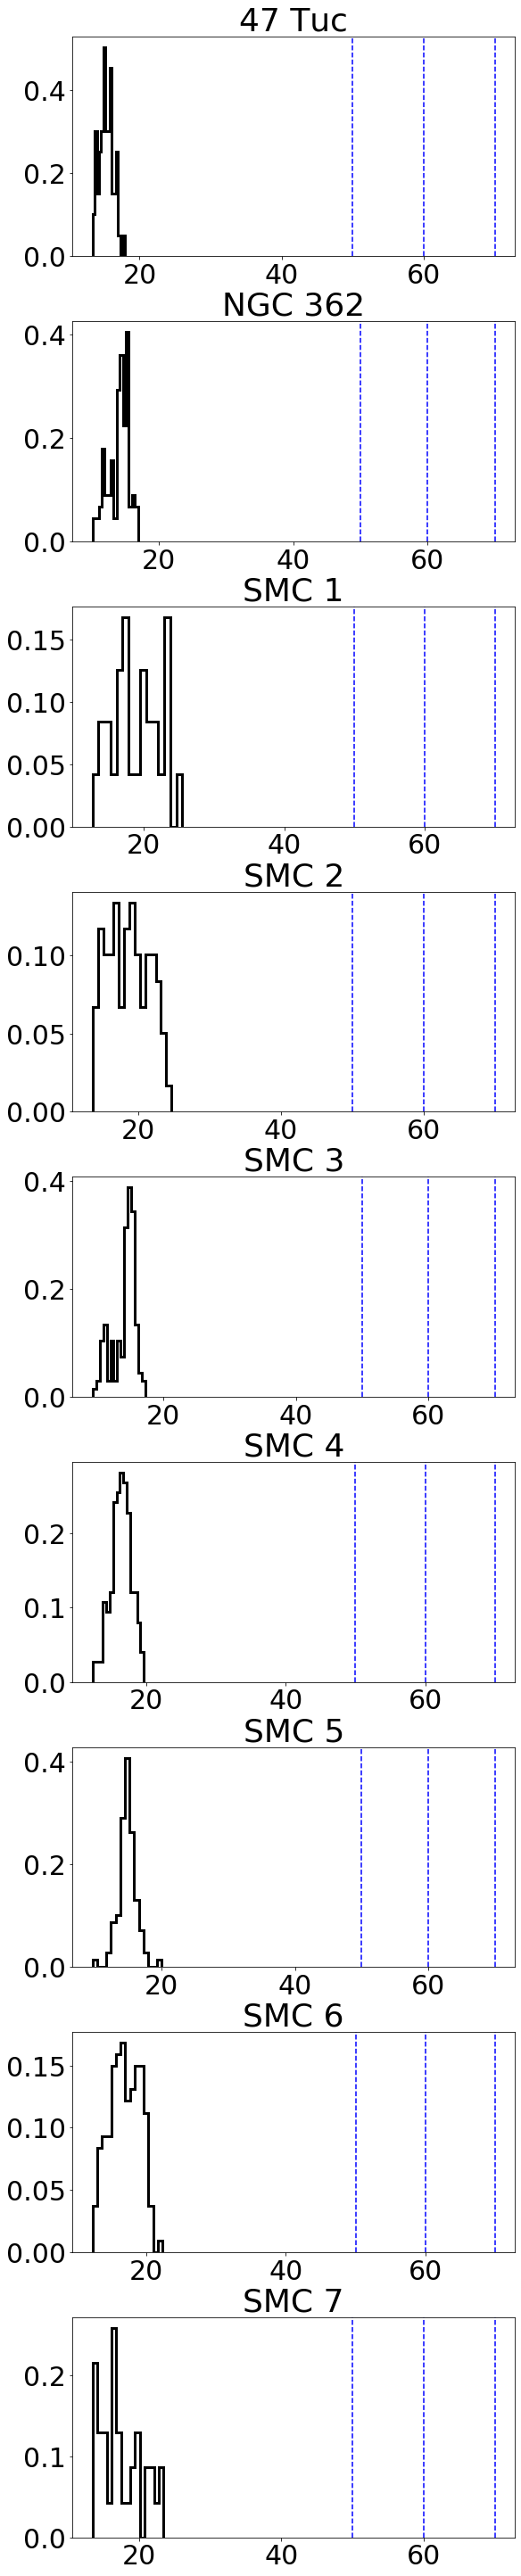

In [191]:
dist_list = [dist47,dist362,dist1,dist2,dist3,dist4,dist5,dist6,dist7]
dist_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(dist_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k',
               label='{}'.format(dist_label[i]))
    
#     ax[i].set_ylim(top=0.07)
#     ax[i].set_xlim(30,135)
    
    ax[i].set_title(r'{}'.format(dist_label[i]))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.tight_layout(pad=0.1)

plt.show()

In [179]:
for i in range(len(dist_list)):
    print('Mean Field {}:'.format(dist_label[i]), np.mean(dist_list[i]))
    print('Media Field {}:'.format(dist_label[i]), np.median(dist_list[i]))
    print(r'-----')

Mean Field 47 Tuc: 15.31516
Media Field 47 Tuc: 15.275808
-----
Mean Field NGC 362: 13.966735
Media Field NGC 362: 14.289088
-----
Mean Field SMC 1: 18.852911
Media Field SMC 1: 18.661697
-----
Mean Field SMC 2: 18.620369
Media Field SMC 2: 18.508133
-----
Mean Field SMC 3: 14.050896
Media Field SMC 3: 14.60424
-----
Mean Field SMC 4: 16.371614
Media Field SMC 4: 16.444332
-----
Mean Field SMC 5: 14.770019
Media Field SMC 5: 14.786994
-----
Mean Field SMC 6: 16.82107
Media Field SMC 6: 16.825592
-----
Mean Field SMC 7: 17.530733
Media Field SMC 7: 16.809746
-----


In [115]:
np.mean(rc_gaia['phot_g_mean_mag'])

19.21171

In [180]:
rc_gaia.columns

ColDefs(
    name = 'solution_id'; format = 'K'
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'
    name = 'random_index'; format = 'K'
    name = 'ref_epoch'; format = 'D'; unit = 'yr'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = 'mas'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = 'mas'
    name = 'parallax'; format = 'D'; unit = 'mas'
    name = 'parallax_error'; format = 'D'; unit = 'mas'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmra_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec'; format = 'D'; unit = 'mas.yr**-1'
    name = 'pmdec_error'; format = 'D'; unit = 'mas.yr**-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_corr'; format = 'E'
    name = 'ra_pmdec_corr'; format = 'E'
    name = 'dec_parallax_corr'; format = 'E'
    na

In [184]:
smc_nobloop.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '36A'
    name = 'ASPCAP_ID'; format = '48A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '45A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '10A'
    name 

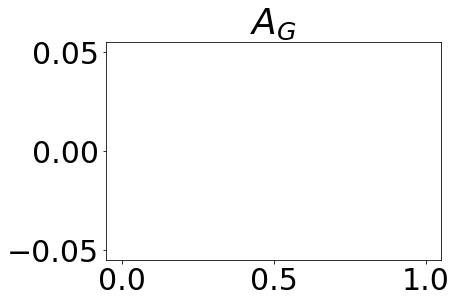

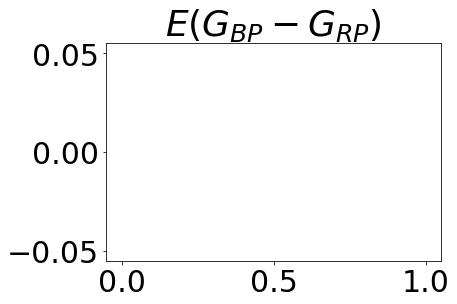

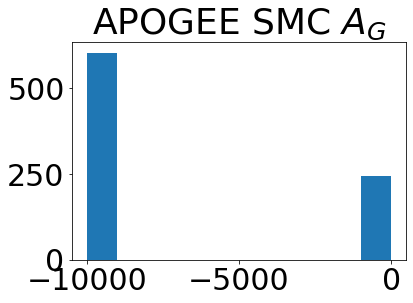

In [188]:
cln_a_g = np.where(np.isfinite(rc_gaia['a_g_val']))
plt.hist(rc_gaia['a_g_val'][cln_a_g])
plt.title(r'$A_G$')
plt.show()

cln_e_bp_rp = np.where(np.isfinite(rc_gaia['e_bp_min_rp_val']))
plt.hist(rc_gaia['e_bp_min_rp_val'][cln_e_bp_rp])
plt.title(r'$E(G_{BP}-G_{RP})$')
plt.show()

plt.hist(smc_nobloop['GAIA_A_G_VAL'])
plt.title(r'APOGEE SMC $A_G$')
plt.show()

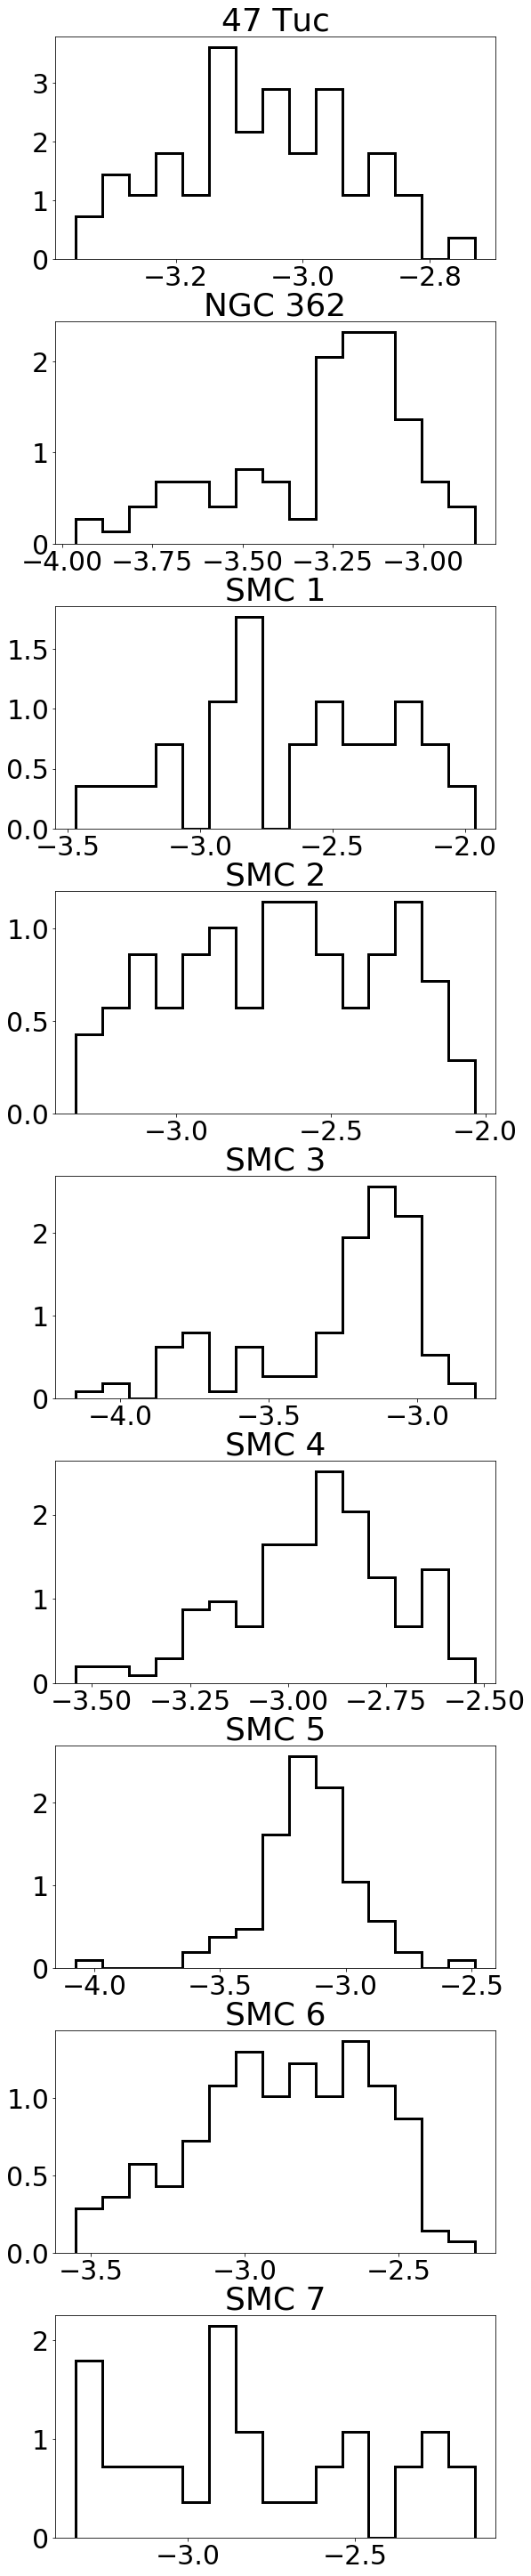

In [158]:
gmag_list = [tuc47['GAIA_GMAG'],n362['GAIA_GMAG'],smc1['GAIA_GMAG'],smc2['GAIA_GMAG'],smc3['GAIA_GMAG'],
             smc4['GAIA_GMAG'],smc5['GAIA_GMAG'],smc6['GAIA_GMAG'],smc7['GAIA_GMAG']]
gmag_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist((gmag_list[i]-np.median(rc_gaia['phot_g_mean_mag']))/5.,density=True,bins=15,histtype='step',
               lw=3.0,color='k',label='{}'.format(gmag_label[i]))
#     ax[i].hist(rc_gaia['phot_g_mean_mag'],density=True,bins=15,histtype='step',
#                lw=3.0,color='r')    
#     ax[i].set_ylim(top=0.07)
#     ax[i].set_xlim(30,135)
    
#     ax[i].legend(loc='upper right')
    ax[i].set_title(r'{}'.format(dist_label[i]))
    
#     ax[i].axvline(50,ls='--',c='b')
#     ax[i].axvline(60,ls='--',c='b')
#     ax[i].axvline(70,ls='--',c='b')

plt.tight_layout(pad=0.)

# plt.savefig('disthist.pdf',bbox_inches='tight')
plt.show()